# Pairs Trading Strategy development using Machine Learning

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
import yfinance as yf 
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from scipy import stats
from statsmodels.tsa.stattools import coint 

import warnings
warnings.filterwarnings('ignore') 

### 1. Fetch Data

In [2]:
indices = pd.read_csv('Stocks_Industry.csv') 
indices.head() 

Unnamed: 0       Industry
0   AXISCADES.NS      Computers
1    BAGFILMS.NS  Entertainment
2  BAJAJ-AUTO.NS           Auto
3    BAJAJCON.NS           Auto
4   BAJAJELEC.NS     Appliances

In [3]:
indices.rename(columns={'Unnamed: 0':'Tickers'},inplace=True)
indices.head(3) 

Tickers       Industry
0   AXISCADES.NS      Computers
1    BAGFILMS.NS  Entertainment
2  BAJAJ-AUTO.NS           Auto

In [4]:
data = pd.DataFrame() 
tickers = indices['Tickers'].to_list() 
start_date = '2020-01-01' 
end_date = '2023-12-31' 

# for tick in tickers:
#     data[f'{tick}'] = yf.download(tick,start=start_date,end=end_date)['Adj Close'] 
# data.to_csv('AdjCloseData.csv') 

In [5]:
data = pd.read_csv('AdjCloseData.csv') 
data.head() 

Date  AXISCADES.NS  BAGFILMS.NS  BAJAJ-AUTO.NS  BAJAJCON.NS  \
0  2020-01-01     53.250000         1.90    2703.128906   209.491241   
1  2020-01-02     55.500000         1.90    2678.157715   210.629028   
2  2020-01-03     55.200001         1.90    2636.153564   210.016373   
3  2020-01-06     53.599998         1.85    2606.634521   204.852402   
4  2020-01-07     53.650002         1.90    2606.891846   206.471619   

   BAJAJELEC.NS  BAJAJFINSV.NS  BAJAJHIND.NS  BAJAJHLDNG.NS  BAJFINANCE.NS  \
0    326.447754     935.670593          7.15    3111.801270    4160.838379   
1    330.799713     948.356201          7.05    3201.652100    4175.343262   
2    322.503662     932.418213          6.95    3195.524170    4123.619141   
3    324.226379     902.173462          6.80    3179.397217    3930.145264   
4    326.493011     907.456177          7.10    3130.186035    3940.912842   

   ...      ATUL.NS  ATULAUTO.NS  AURIONPRO.NS  AUROPHARMA.NS  AUSOMENT.NS  \
0  ...  3994.176758   254.800003     30.428905     442.845734    35.872810   
1  ...  4039.422119   252.949997     30.056913     446.229248    35.775589   
2  ...  4064.798584   249.649994     29.610525     444.972504    34.997864   
3  ...  4081.667236   245.699997     28.916140     428.731934    34.025696   
4  ...  4146.387207   248.000000     29.387329     437.335602    34.608994   

   AUTOAXLES.NS  AUTOIND.NS  AUTOLITIND.NS  AVTNPL.NS  AXISBANK.NS  
0    788.186401   24.750000            NaN  29.706486   745.452026  
1    812.228149   25.049999            NaN  33.525887   753.666260  
2    806.265869   24.750000            NaN  32.064137   739.726990  
3    774.386414   23.700001            NaN  30.508087   720.112366  
4    797.899292   24.000000            NaN  31.403996   722.601562  

[5 rows x 1028 columns]

In [6]:
data['Date'] = pd.to_datetime(data['Date']) 
data.set_index('Date',inplace=True) 
data.head() 

AXISCADES.NS  BAGFILMS.NS  BAJAJ-AUTO.NS  BAJAJCON.NS  \
Date                                                                
2020-01-01     53.250000         1.90    2703.128906   209.491241   
2020-01-02     55.500000         1.90    2678.157715   210.629028   
2020-01-03     55.200001         1.90    2636.153564   210.016373   
2020-01-06     53.599998         1.85    2606.634521   204.852402   
2020-01-07     53.650002         1.90    2606.891846   206.471619   

            BAJAJELEC.NS  BAJAJFINSV.NS  BAJAJHIND.NS  BAJAJHLDNG.NS  \
Date                                                                   
2020-01-01    326.447754     935.670593          7.15    3111.801270   
2020-01-02    330.799713     948.356201          7.05    3201.652100   
2020-01-03    322.503662     932.418213          6.95    3195.524170   
2020-01-06    324.226379     902.173462          6.80    3179.397217   
2020-01-07    326.493011     907.456177          7.10    3130.186035   

            BAJFINANCE.NS  BALAJITELE.NS  ...      ATUL.NS  ATULAUTO.NS  \
Date                                      ...                             
2020-01-01    4160.838379      50.312054  ...  3994.176758   254.800003   
2020-01-02    4175.343262      52.587727  ...  4039.422119   252.949997   
2020-01-03    4123.619141      52.835083  ...  4064.798584   249.649994   
2020-01-06    3930.145264      50.707825  ...  4081.667236   245.699997   
2020-01-07    3940.912842      51.153065  ...  4146.387207   248.000000   

            AURIONPRO.NS  AUROPHARMA.NS  AUSOMENT.NS  AUTOAXLES.NS  \
Date                                                                 
2020-01-01     30.428905     442.845734    35.872810    788.186401   
2020-01-02     30.056913     446.229248    35.775589    812.228149   
2020-01-03     29.610525     444.972504    34.997864    806.265869   
2020-01-06     28.916140     428.731934    34.025696    774.386414   
2020-01-07     29.387329     437.335602    34.608994    797.899292   

            AUTOIND.NS  AUTOLITIND.NS  AVTNPL.NS  AXISBANK.NS  
Date                                                           
2020-01-01   24.750000            NaN  29.706486   745.452026  
2020-01-02   25.049999            NaN  33.525887   753.666260  
2020-01-03   24.750000            NaN  32.064137   739.726990  
2020-01-06   23.700001            NaN  30.508087   720.112366  
2020-01-07   24.000000            NaN  31.403996   722.601562  

[5 rows x 1027 columns]

In [7]:
nan_columns = data.columns[data.isna().any()].to_list()
len(nan_columns)   

92

In [8]:
data.dropna(axis=1,inplace=True)
data.shape 

(992, 935)

In [9]:
nifty_50 = yf.download('^NSEI',start=start_date,end=end_date)['Adj Close']
nifty_50.head() 

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-01    12182.500000
2020-01-02    12282.200195
2020-01-03    12226.650391
2020-01-06    11993.049805
2020-01-07    12052.950195
Name: Adj Close, dtype: float64

In [10]:
returns = data.pct_change().dropna()
returns.head() 

AXISCADES.NS  BAGFILMS.NS  BAJAJ-AUTO.NS  BAJAJCON.NS  \
Date                                                                
2020-01-02      0.042254     0.000000      -0.009238     0.005431   
2020-01-03     -0.005405     0.000000      -0.015684    -0.002909   
2020-01-06     -0.028986    -0.026316      -0.011198    -0.024588   
2020-01-07      0.000933     0.027027       0.000099     0.007904   
2020-01-08     -0.015843     0.000000       0.007011    -0.000636   

            BAJAJELEC.NS  BAJAJFINSV.NS  BAJAJHIND.NS  BAJAJHLDNG.NS  \
Date                                                                   
2020-01-02      0.013331       0.013558     -0.013986       0.028874   
2020-01-03     -0.025079      -0.016806     -0.014184      -0.001914   
2020-01-06      0.005342      -0.032437     -0.021583      -0.005047   
2020-01-07      0.006991       0.005856      0.044118      -0.015478   
2020-01-08     -0.006942       0.005481     -0.042253       0.006830   

            BAJFINANCE.NS  BALAJITELE.NS  ...   ATFL.NS   ATUL.NS  \
Date                                      ...                       
2020-01-02       0.003486       0.045231  ...  0.030632  0.011328   
2020-01-03      -0.012388       0.004704  ...  0.009409  0.006282   
2020-01-06      -0.046918      -0.040262  ... -0.059406  0.004150   
2020-01-07       0.002740       0.008780  ...  0.013921  0.015856   
2020-01-08       0.010555      -0.048356  ... -0.006826 -0.001957   

            ATULAUTO.NS  AURIONPRO.NS  AUROPHARMA.NS  AUSOMENT.NS  \
Date                                                                
2020-01-02    -0.007261     -0.012225       0.007640    -0.002710   
2020-01-03    -0.013046     -0.014851      -0.002816    -0.021739   
2020-01-06    -0.015822     -0.023451      -0.036498    -0.027778   
2020-01-07     0.009361      0.016295       0.020068     0.017143   
2020-01-08    -0.015323     -0.016034      -0.002321     0.014045   

            AUTOAXLES.NS  AUTOIND.NS  AVTNPL.NS  AXISBANK.NS  
Date                                                          
2020-01-02      0.030503    0.012121   0.128571     0.011019  
2020-01-03     -0.007341   -0.011976  -0.043601    -0.018495  
2020-01-06     -0.039540   -0.042424  -0.048529    -0.026516  
2020-01-07      0.030363    0.012658   0.029366     0.003457  
2020-01-08     -0.000783   -0.008333  -0.007507    -0.001722  

[5 rows x 935 columns]

In [11]:
indice = pd.read_csv('Stocks_Industry.csv')
indice = indice.set_index('Unnamed: 0') 
indice.head()

Industry
Unnamed: 0                  
AXISCADES.NS       Computers
BAGFILMS.NS    Entertainment
BAJAJ-AUTO.NS           Auto
BAJAJCON.NS             Auto
BAJAJELEC.NS      Appliances

In [12]:
df_index = pd.DataFrame(index=data.columns) 
df_index = df_index.join(indice) 
df_index.shape  

(935, 1)

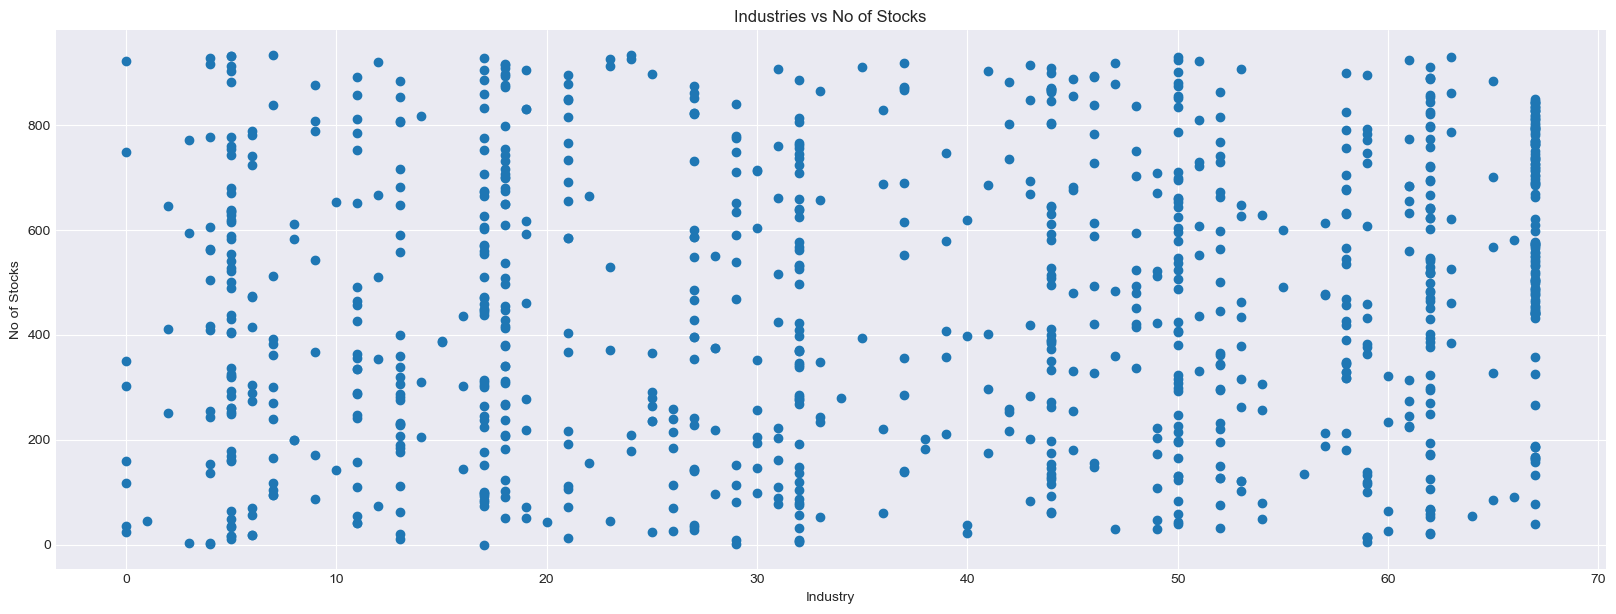

In [14]:
from sklearn.preprocessing import LabelEncoder

indice = df_index.values.flatten().tolist() 
label_encoder = LabelEncoder() 
indus = label_encoder.fit_transform(indice)
ind = indus.reshape(935,1)
y = range(935)
plt.figure(figsize=(20,7)) 
plt.scatter(ind,y)
plt.title('Industries vs No of Stocks') 
plt.xlabel('Industry')
plt.ylabel('No of Stocks') 
plt.grid(True) 

### 2. Find Candidate Pairs

#### Steps:
    1. Classify Stocks into cluster
    2. Looks for strong mean-reverting pair relationships within the cluster

Here, we use DBSCAN. Unlike KMeans, DBSCAN will not form cluster of all available stocks and we donot have to specify the number of clusters. 

#### PCA Decomposition and DBSCAN clustering

In [15]:
pca = PCA(n_components=3) 
pca.fit(returns) 

PCA(n_components=3)

In [16]:
np.cumsum(pca.explained_variance_ratio_)

array([0.19448153, 0.21150257, 0.22091079])

In [17]:
pca.components_.T.shape 

(935, 3)

In [18]:
X = pca.components_.T 
X = np.hstack((pca.components_.T,ind))
X.shape 

(935, 4)

In [19]:
X = preprocessing.StandardScaler().fit_transform(X) 

In [20]:
clf = DBSCAN(eps=0.13,min_samples=2) 
print(clf) 

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
print('Clusters Discovered: %d' % n_clusters_) 

DBSCAN(eps=0.13, min_samples=2)
Clusters Discovered: 21


In [21]:
clustered = clf.labels_
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten()) 
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series!=-1] 

In [22]:
cluster_size_limit = 20
counts = clustered_series.value_counts() 
ticker_count_reduced = counts[(counts>1) & (counts<=cluster_size_limit)]
print(f'Clusters formed : {len(ticker_count_reduced)}')
print(f'Pairs to evaluate : {(ticker_count_reduced*(ticker_count_reduced-1)).sum()}')

Clusters formed : 21
Pairs to evaluate : 50


### 3. Cluster Visualization

In [23]:
x_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=42).fit_transform(X)

Text(0.5, 1.0, 'T-SNE of all stocks with DBSCAN clusters')

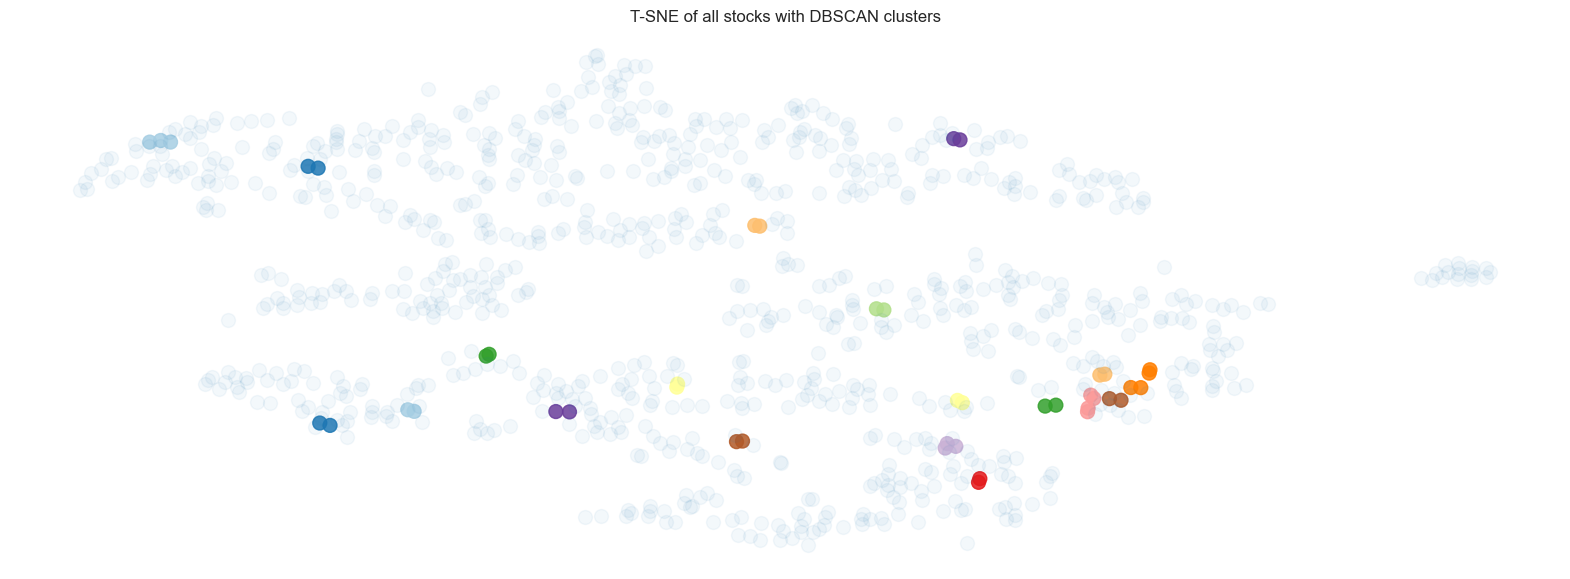

In [24]:
plt.figure(figsize=(20,7))
plt.clf()
plt.axis('off')

plt.scatter(x_tsne[(labels!=-1),0],x_tsne[(labels!=-1),1],
            s=100,alpha=0.85,c=labels[labels!=-1],cmap=cm.Paired)

plt.scatter(x_tsne[(clustered_series_all==-1).values,0],
            x_tsne[(clustered_series_all==-1).values,1],
            s=100, alpha=0.05) 

plt.title('T-SNE of all stocks with DBSCAN clusters') 

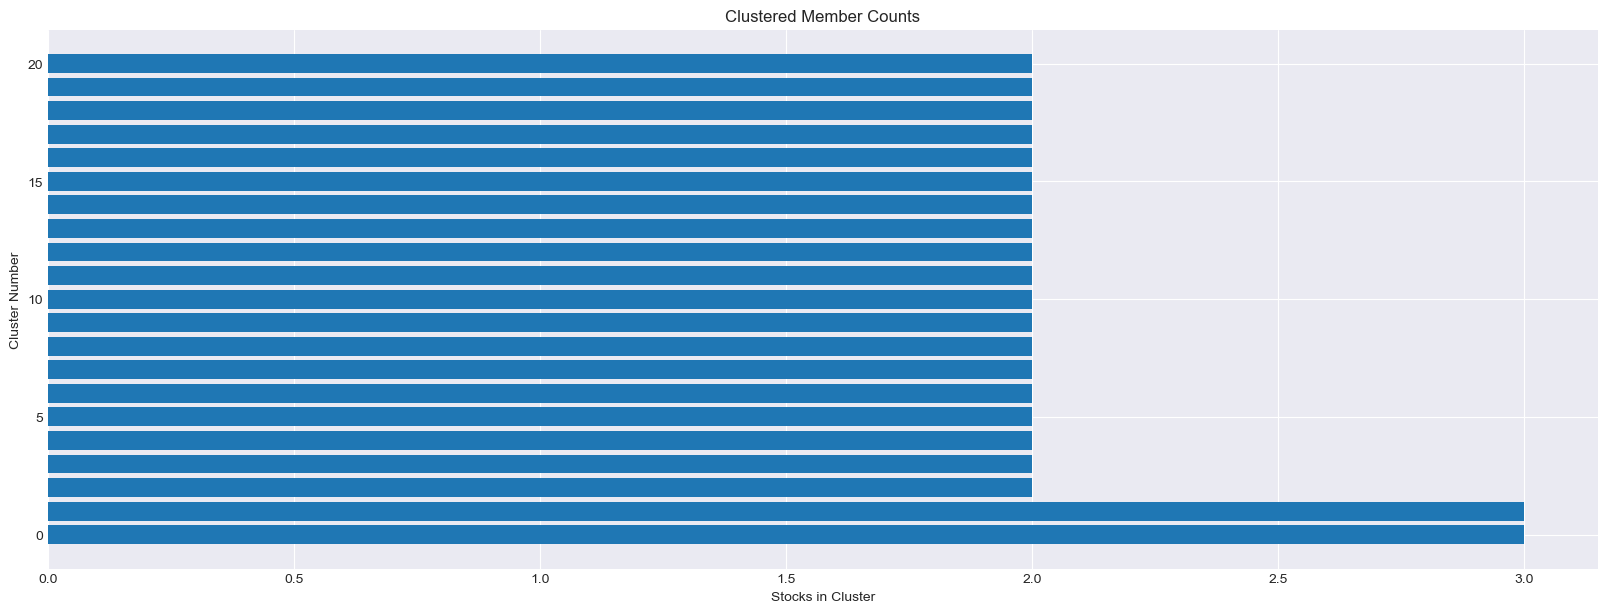

In [25]:
plt.figure(figsize=(20,7)) 
plt.barh(range(len(clustered_series.value_counts())),
         clustered_series.value_counts()) 
plt.title('Clustered Member Counts') 
plt.xlabel('Stocks in Cluster') 
plt.ylabel('Cluster Number') 
plt.show() 

In [26]:
counts = clustered_series.value_counts() 

cluster_visualization_count = list(counts[(counts<=20) & (counts>1)].index)[::-1] 
print(len(cluster_visualization_count)) 

21


<Figure size 2000x700 with 0 Axes>

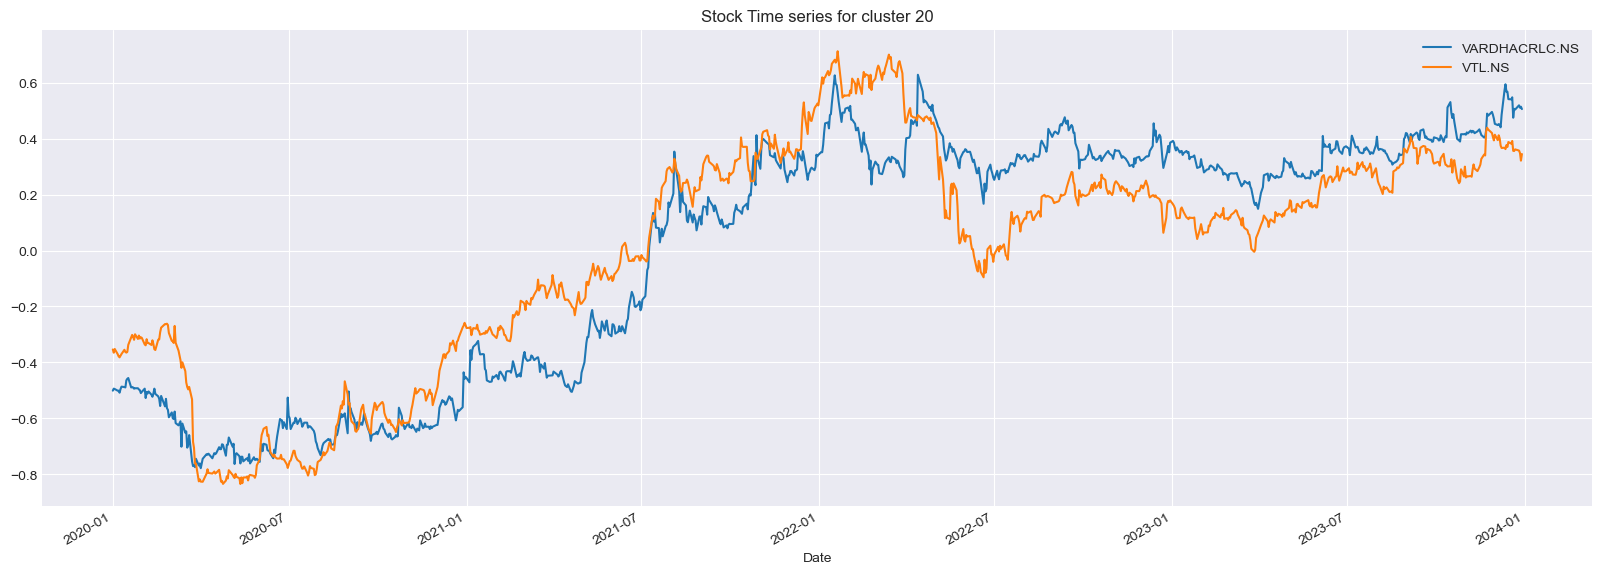

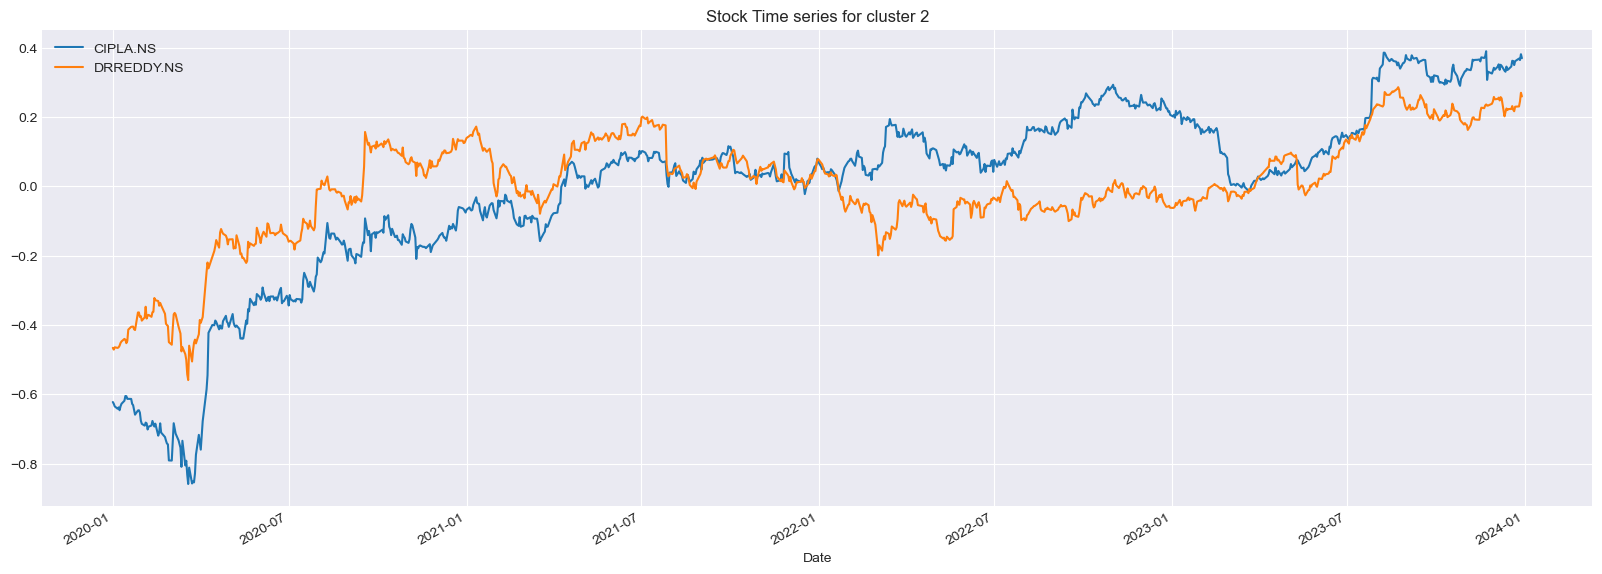

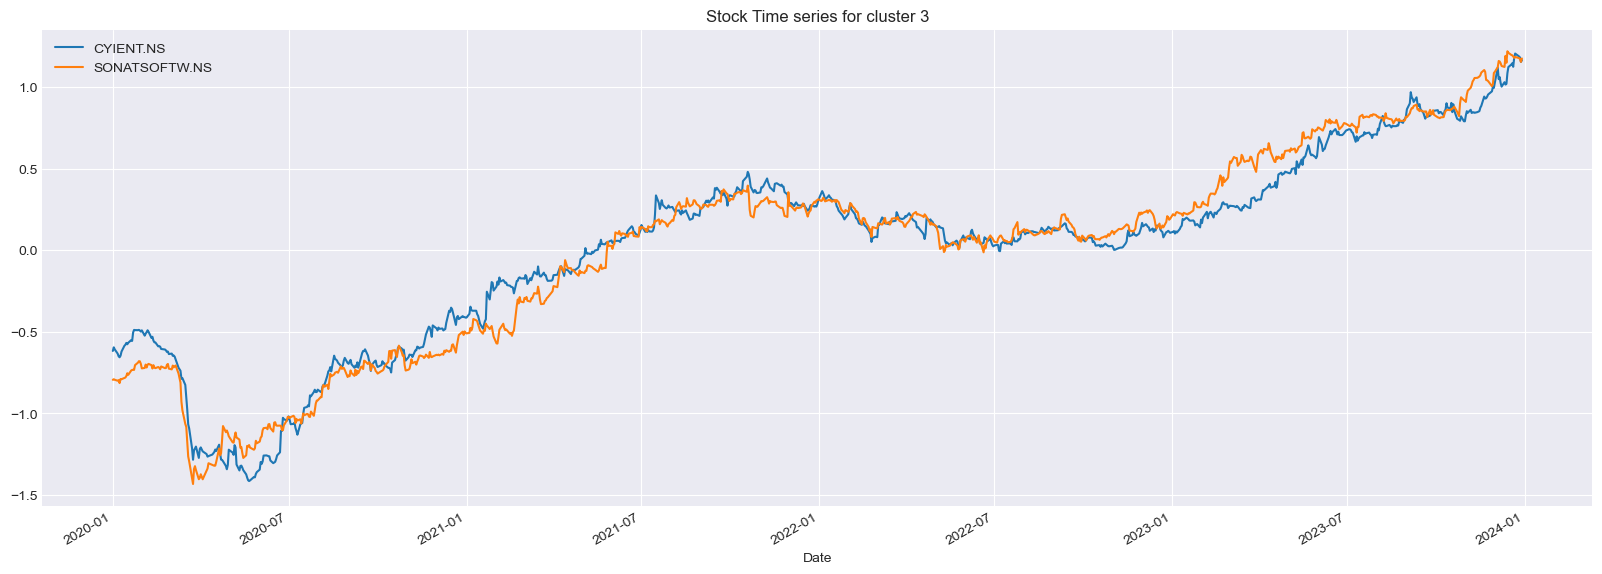

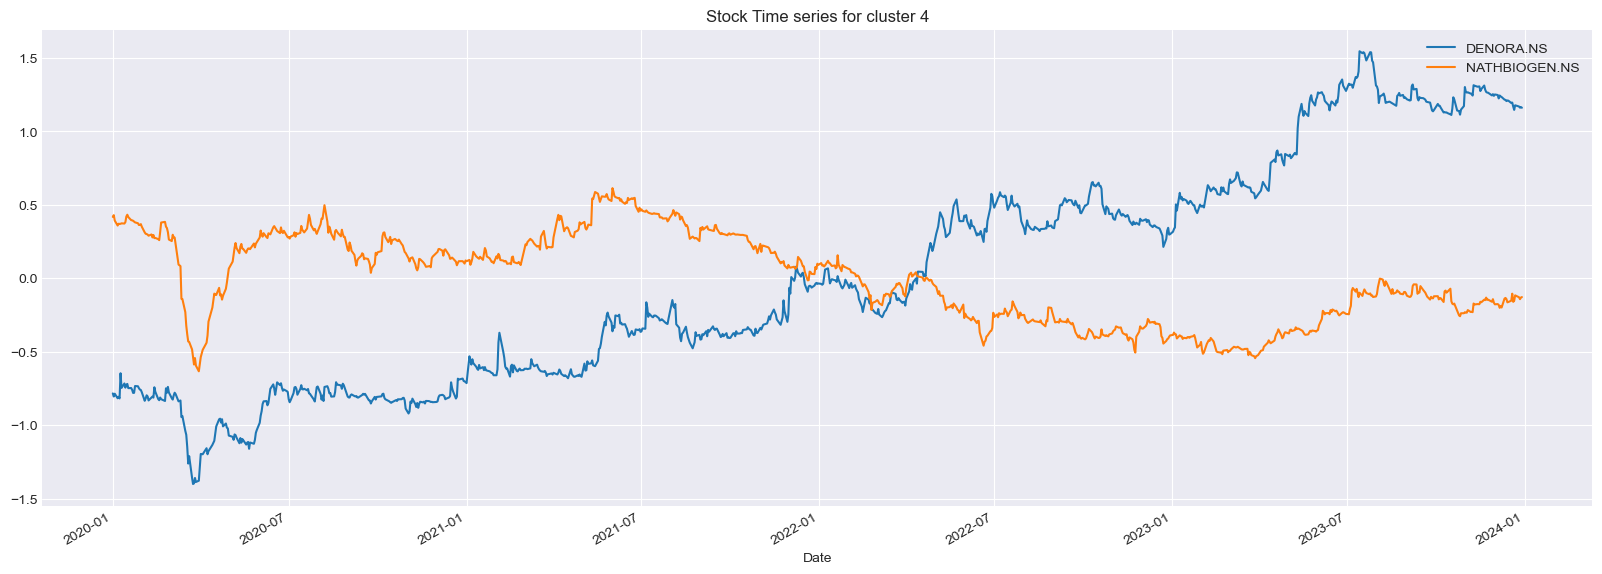

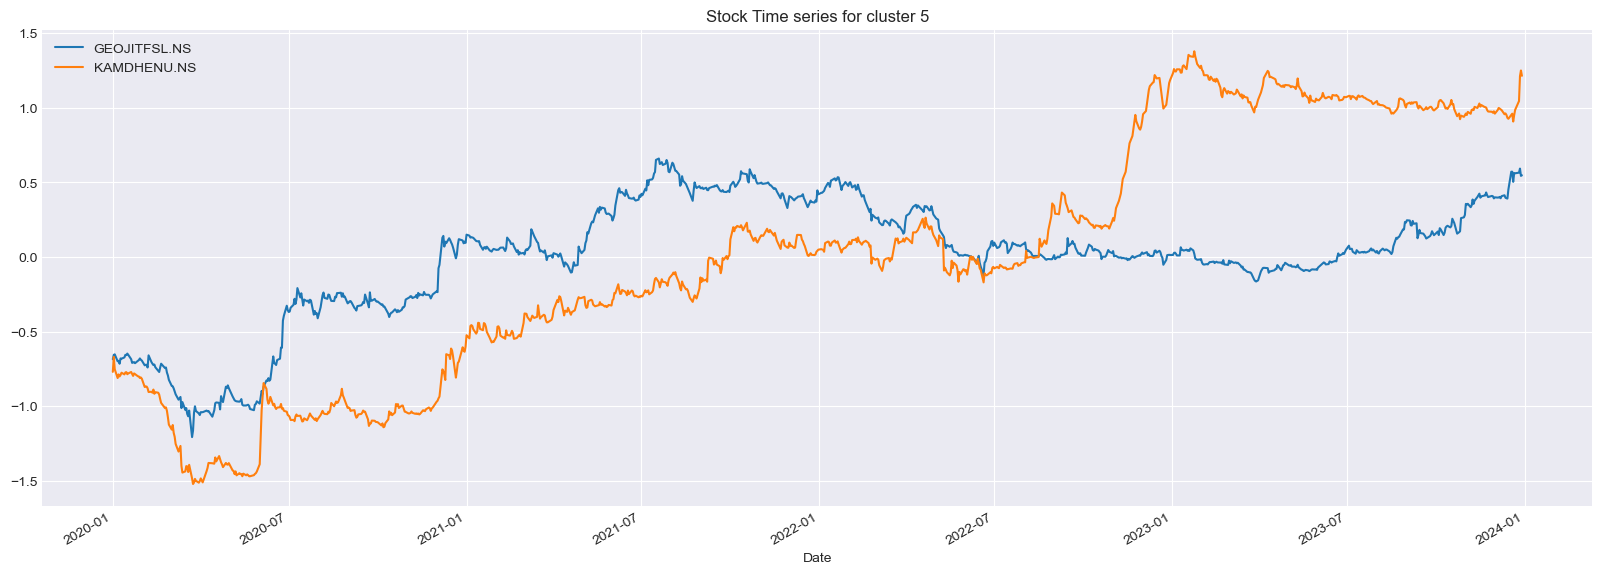

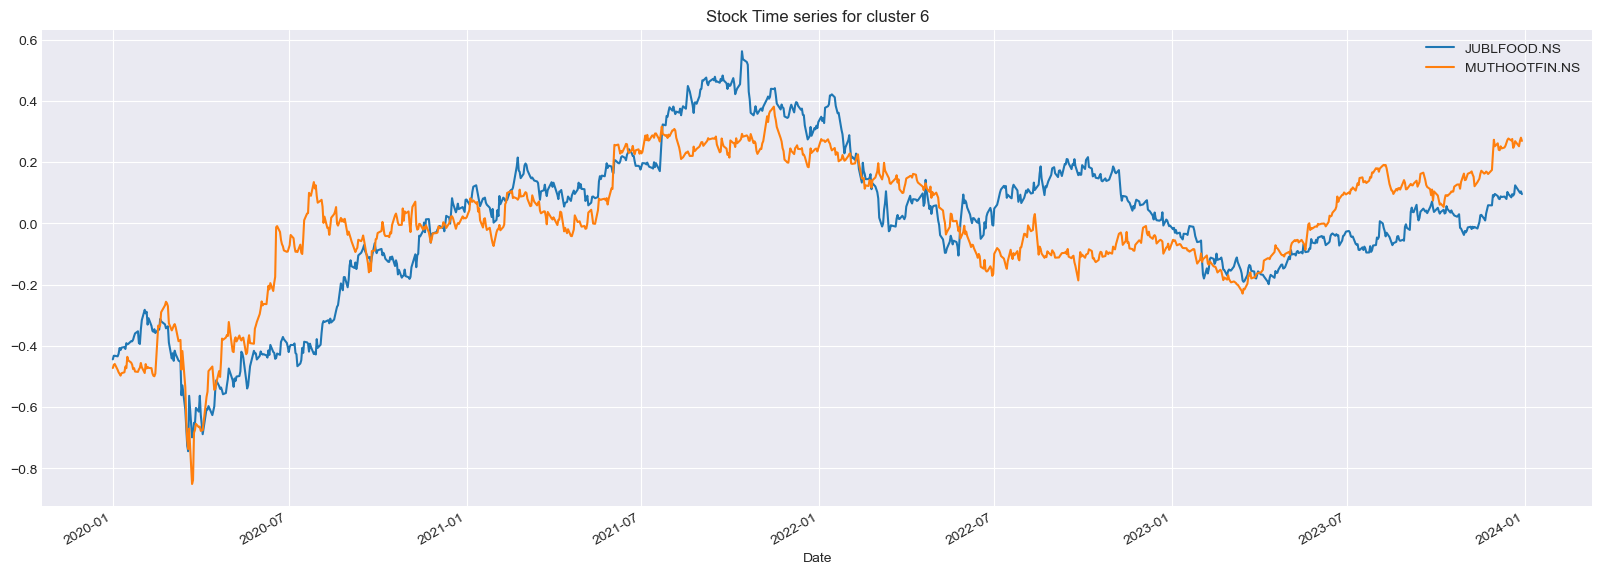

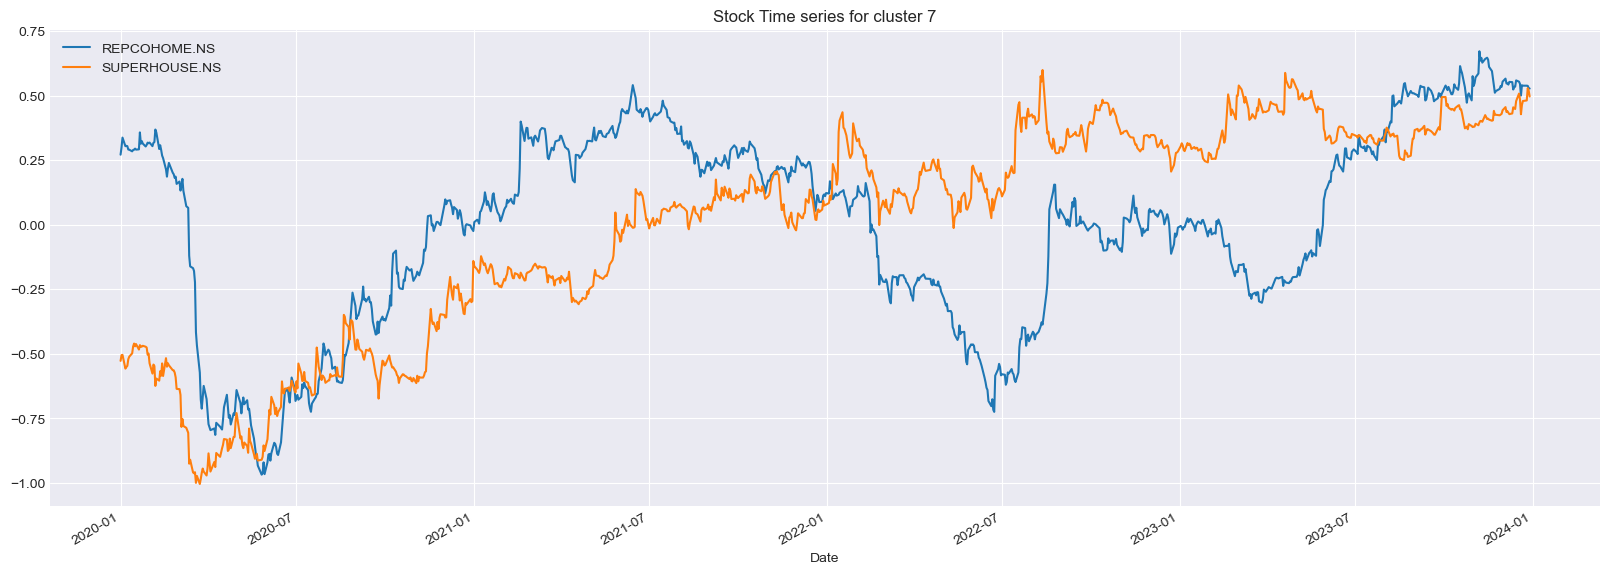

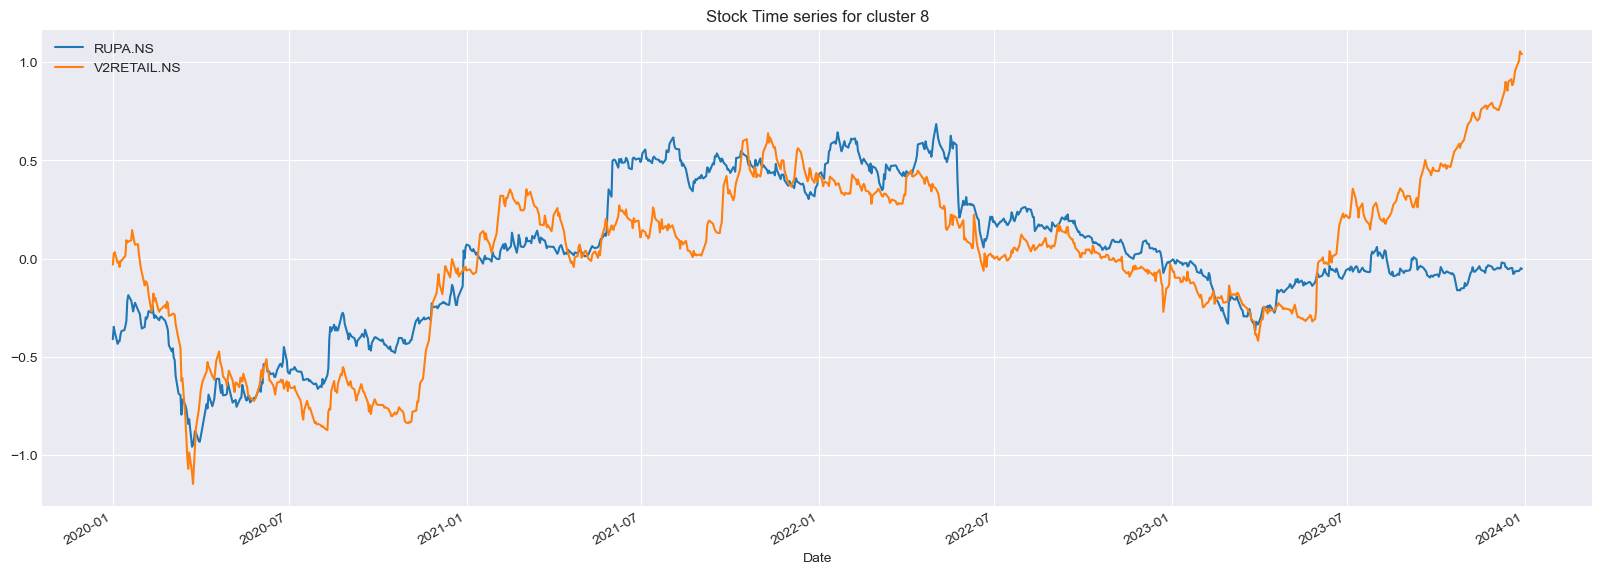

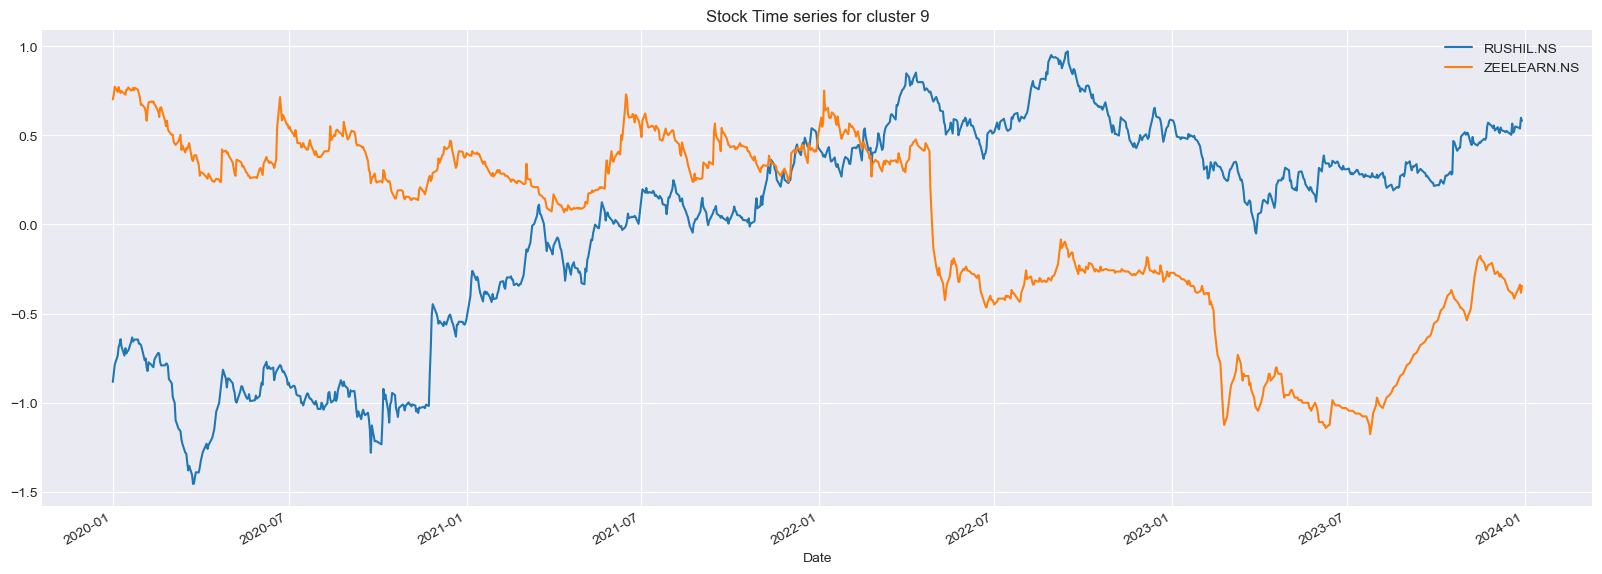

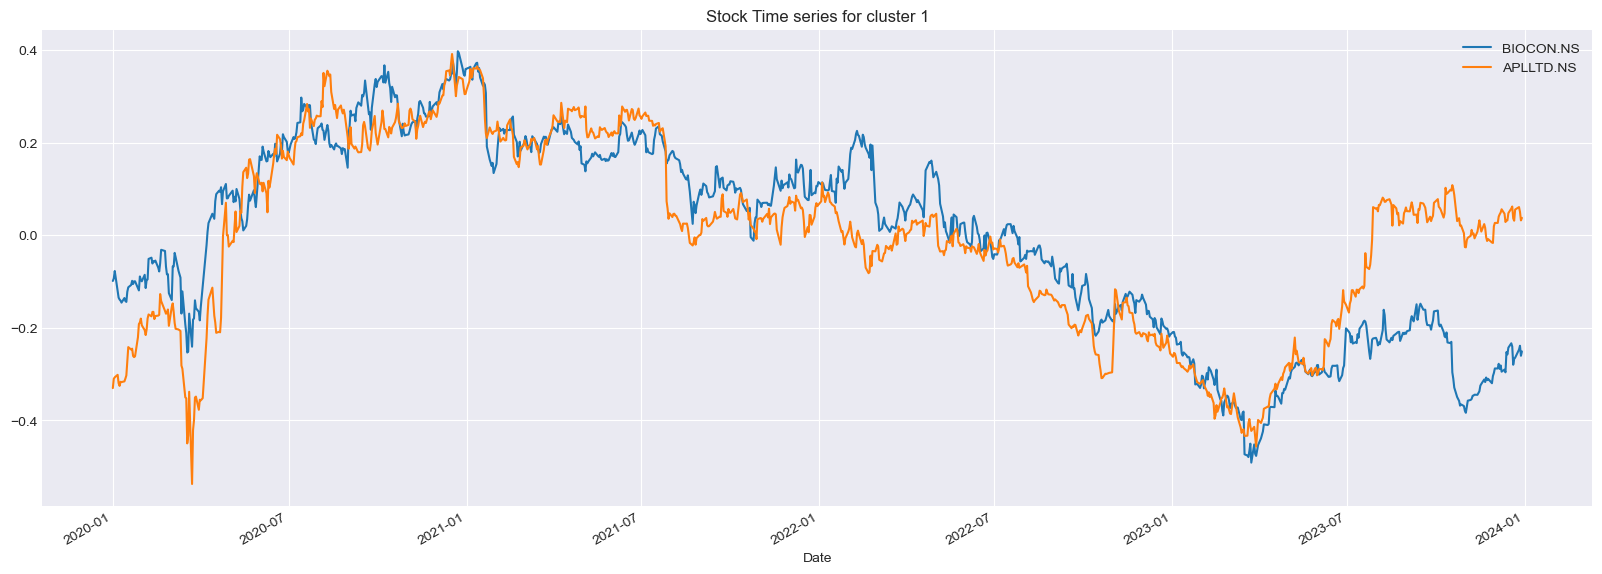

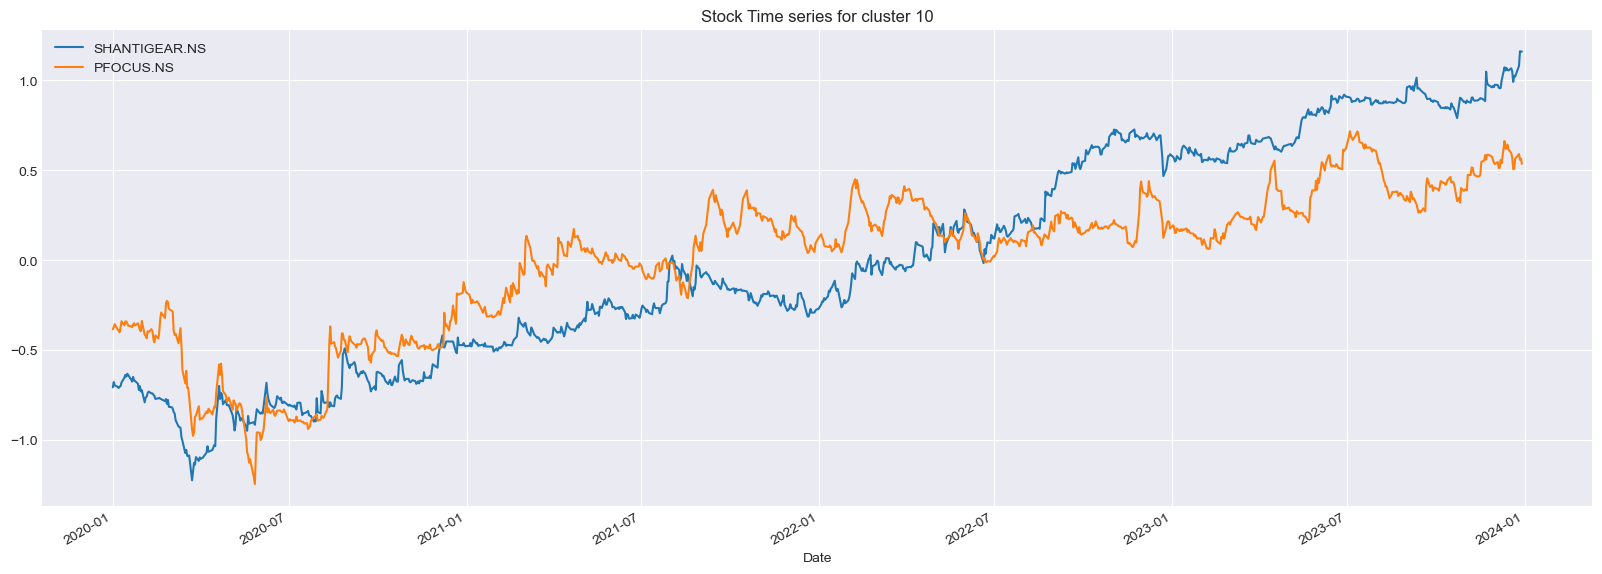

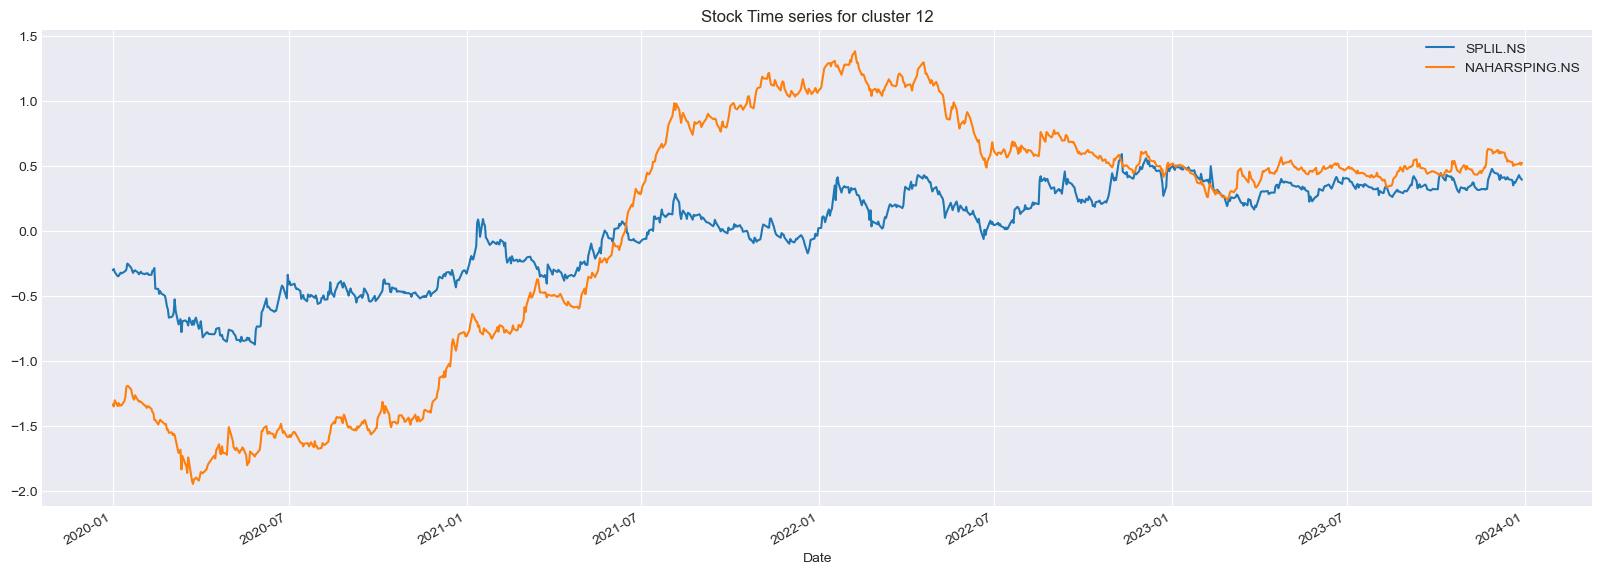

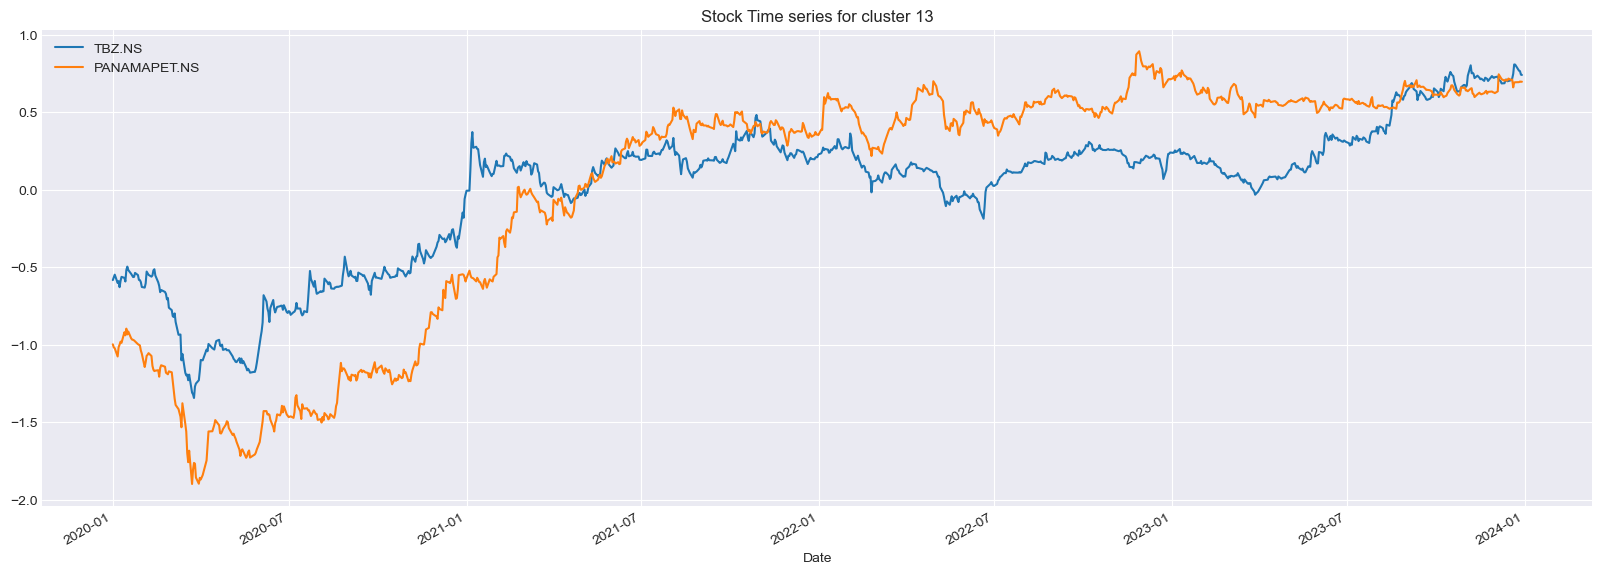

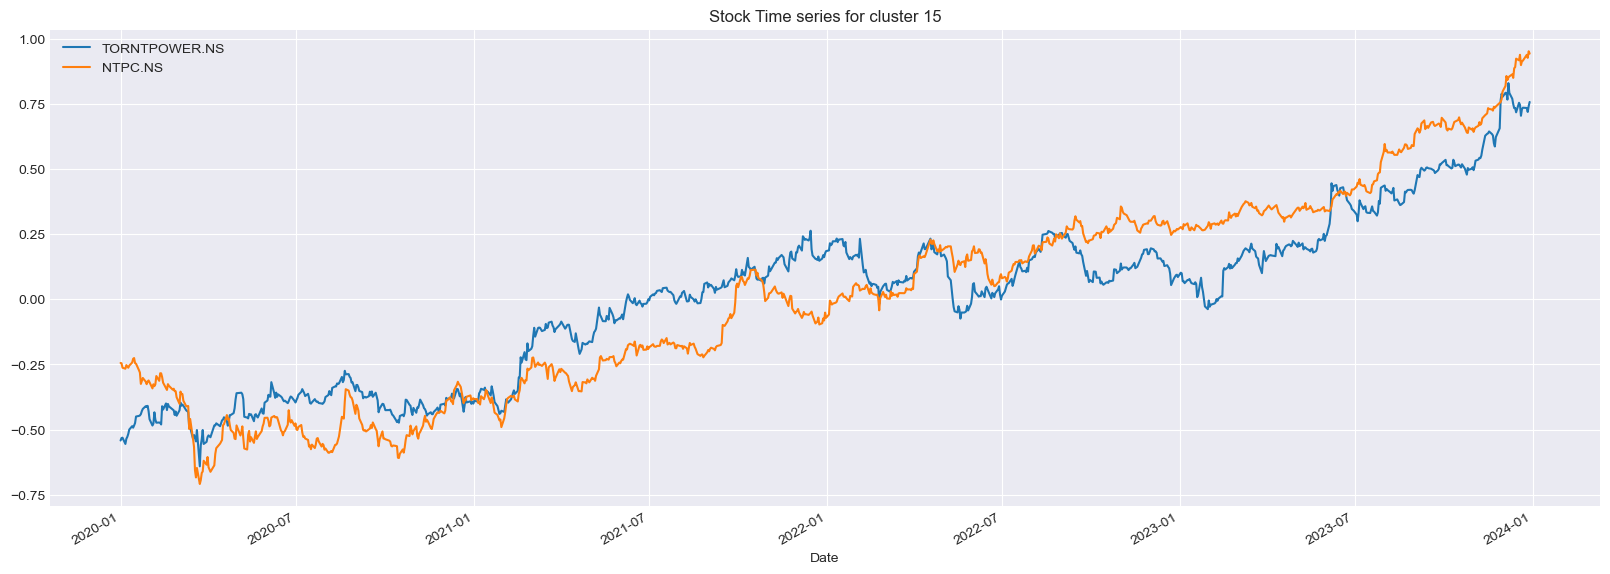

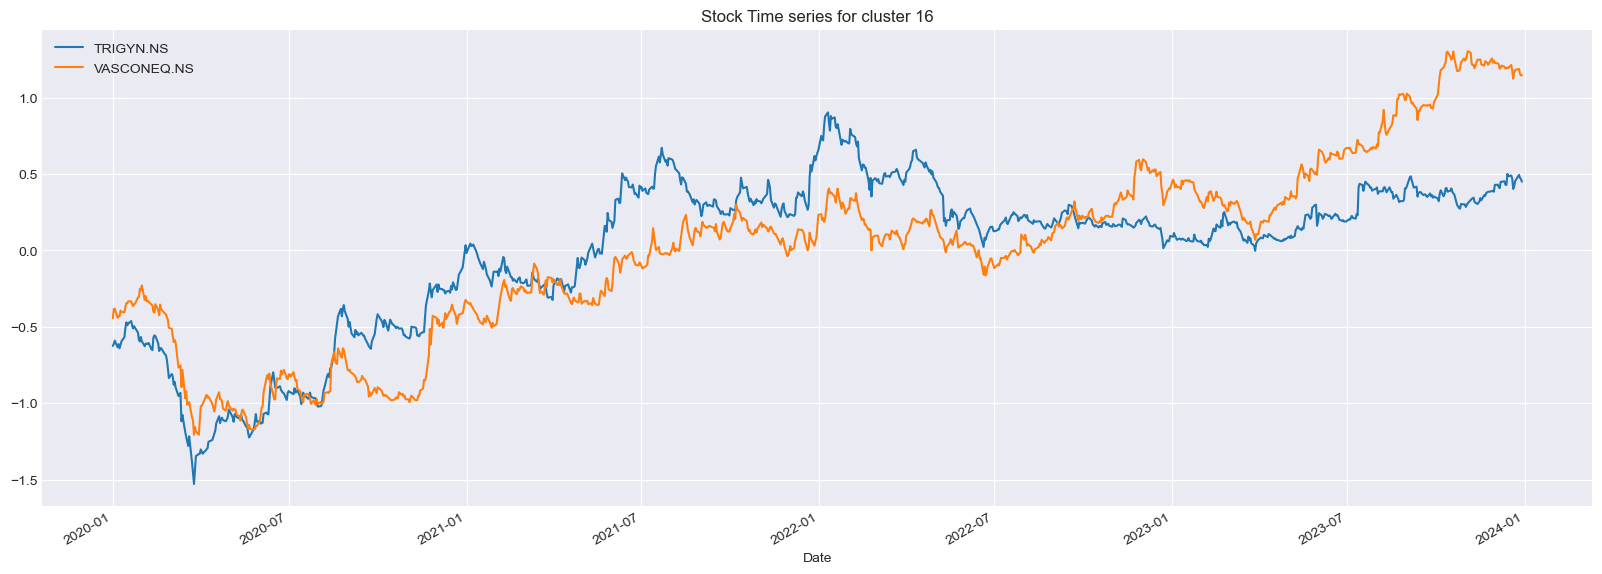

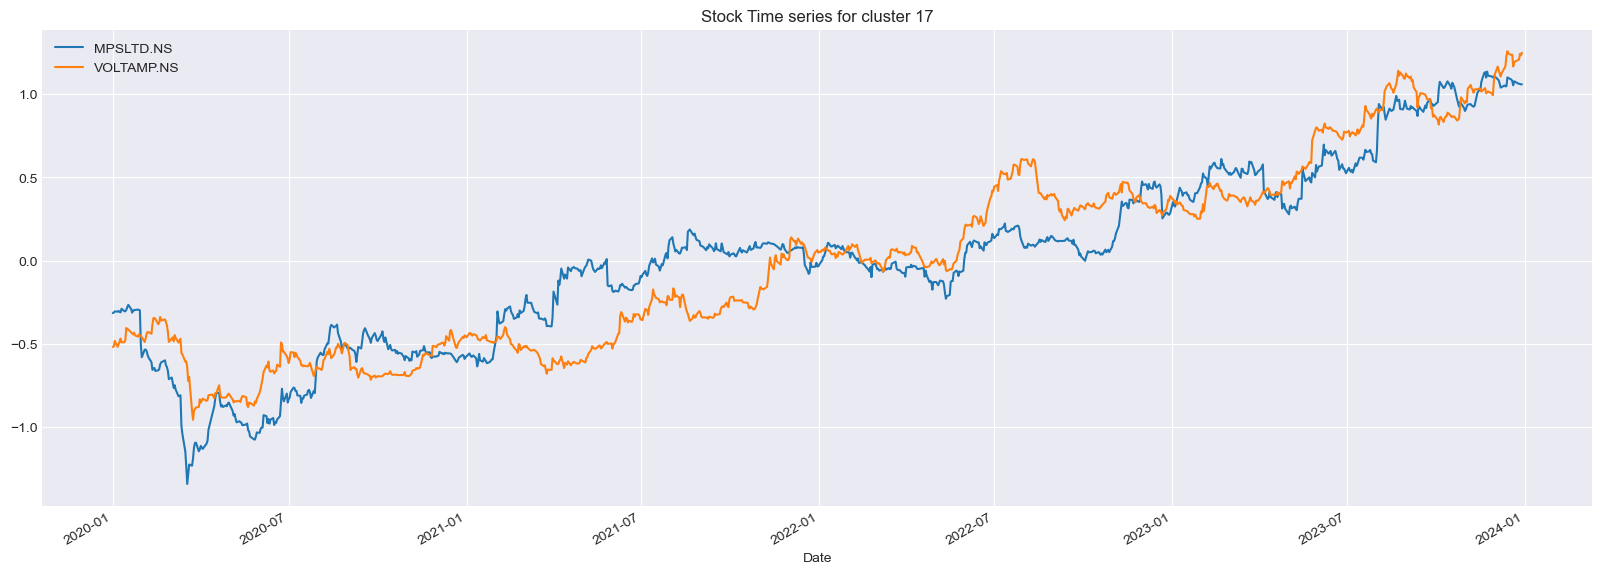

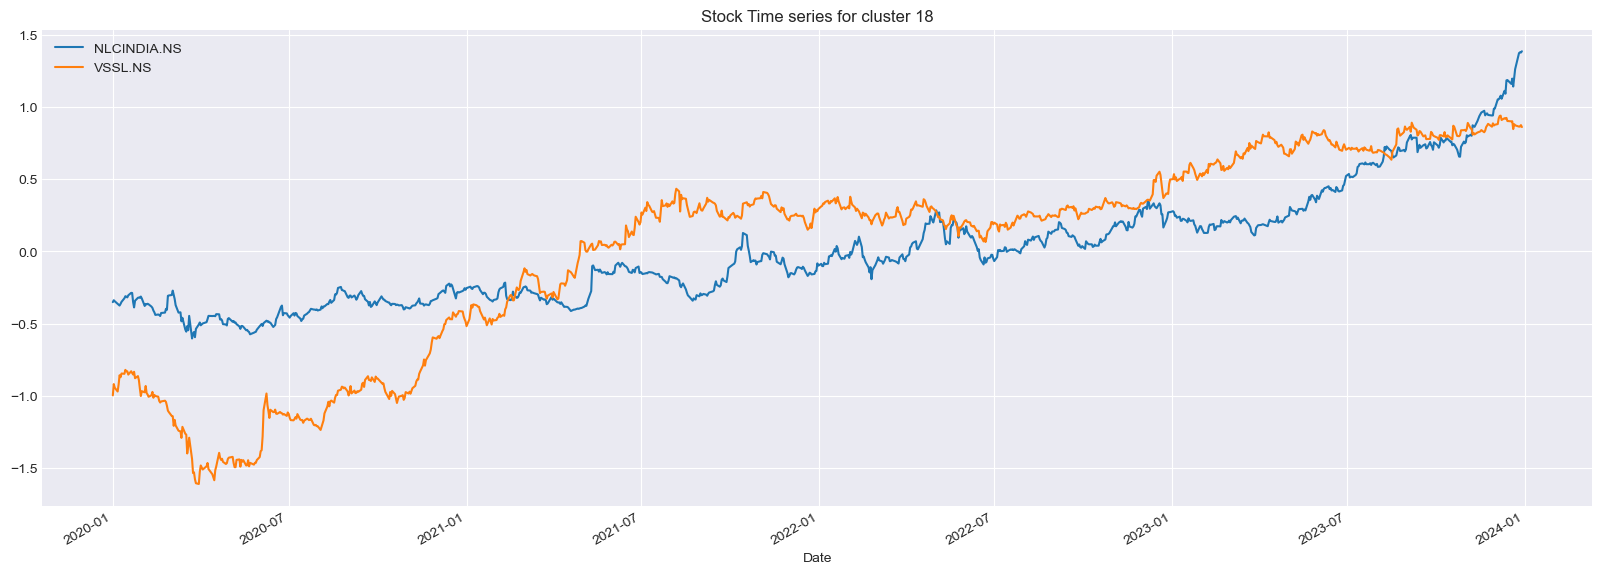

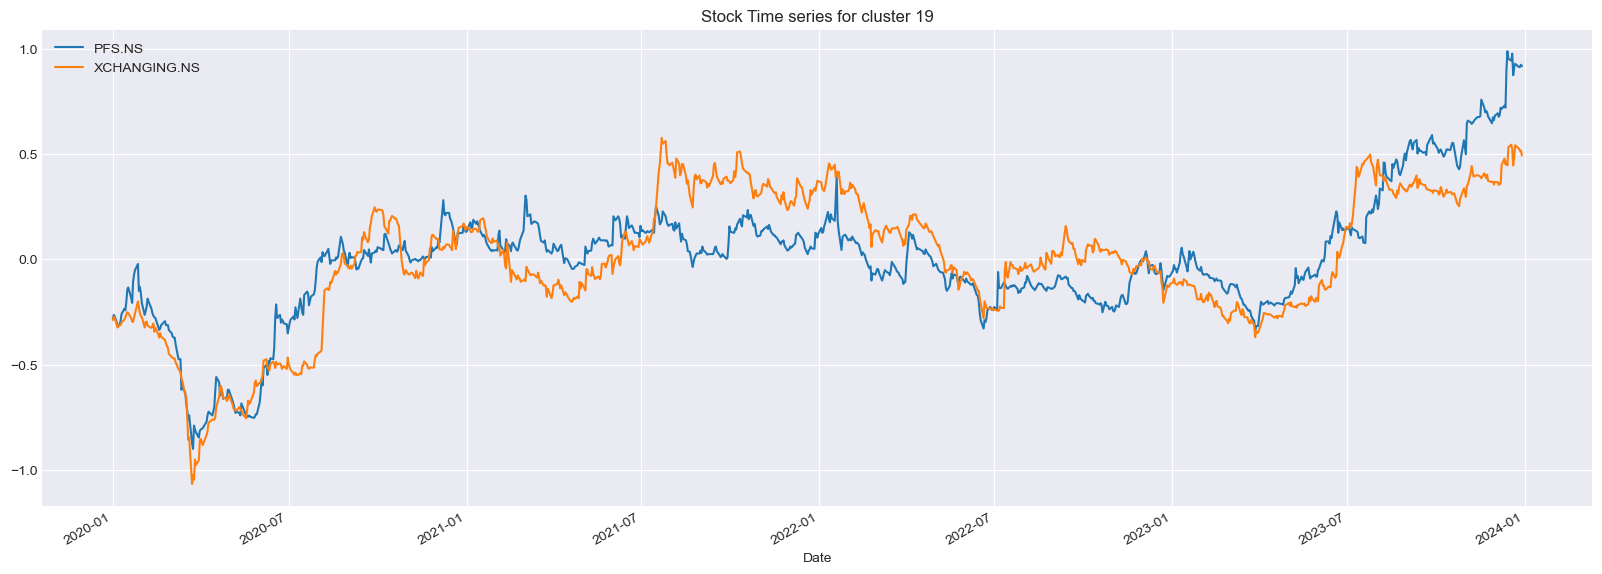

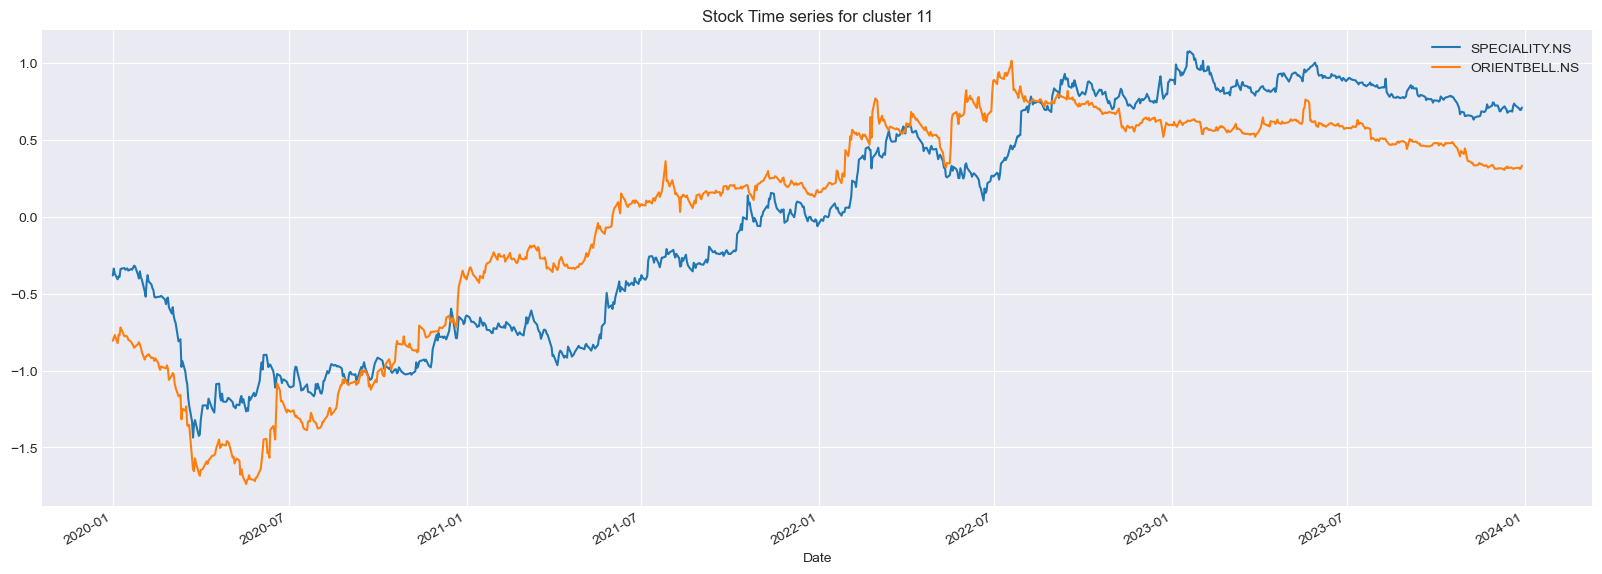

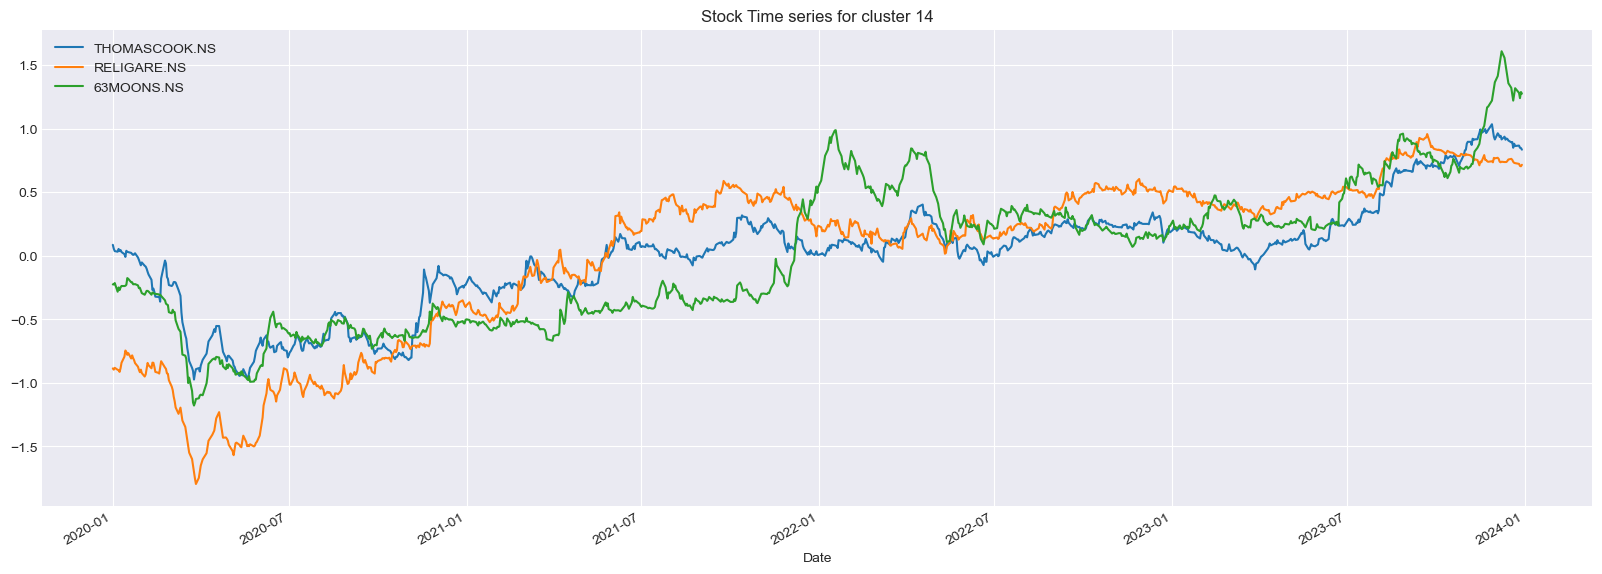

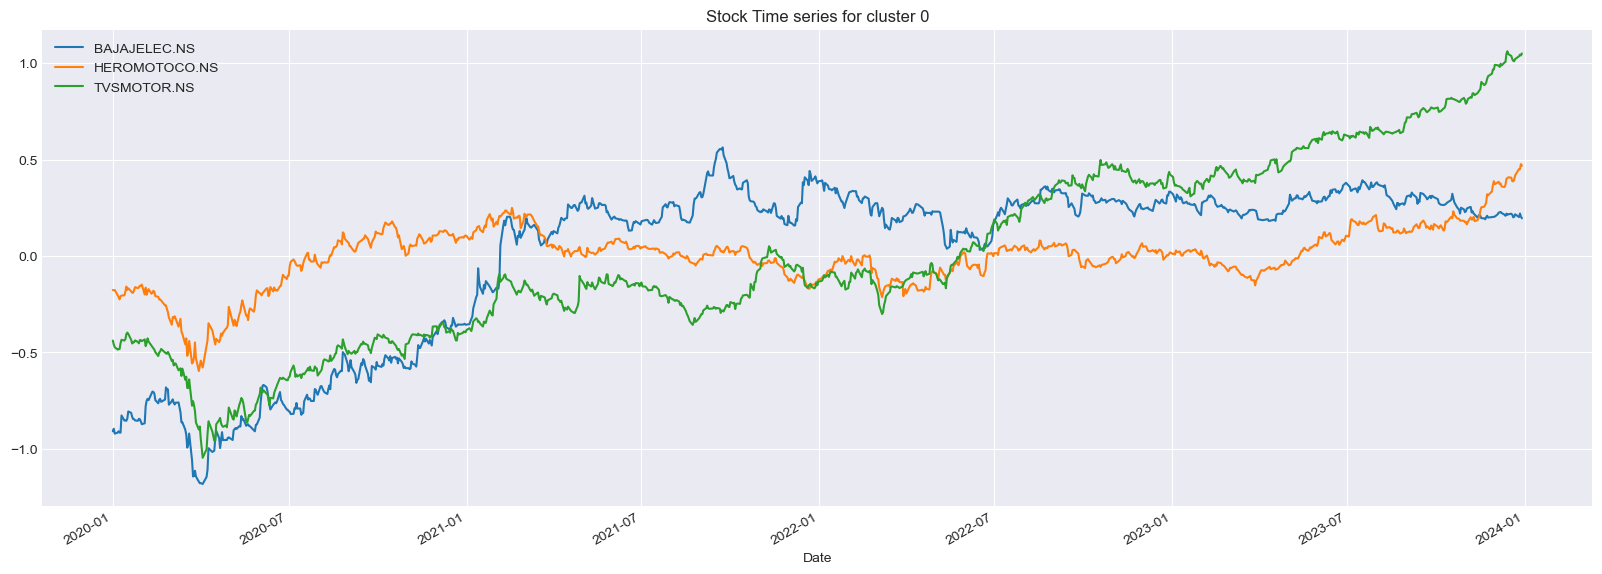

In [27]:
plt.figure(figsize=(20,7)) 

for cluster in cluster_visualization_count:
    tickers = list(clustered_series[clustered_series==cluster].index)
    means = np.log(data[tickers]).mean() 
    dt = np.log(data[tickers]).sub(means) 
    dt.plot(title=f'Stock Time series for cluster {cluster}',figsize=(20,7))
    plt.show() 

### 4. Validating Cointegration relations and Selecting Pairs

In [28]:
def find_coint_pairs(dt, significance=0.05):
    n = dt.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.zeros((n,n))
    keys = dt.keys()
    pairs = [] 
    for i in range(n):
        for j in range(i+1,n):
            S1 = dt[keys[i]]
            S2 = dt[keys[j]]
            result = coint(S1,S2) 
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score 
            pvalue_matrix[i,j] = pvalue
            if pvalue<significance:
                pairs.append((keys[i],keys[j])) 
    return score_matrix, pvalue_matrix, pairs             

In [29]:
cluster_dict = {} 
for i, clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series==clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(data[tickers])
    cluster_dict[clust] = {} 
    cluster_dict[clust]['score_matrix'] = score_matrix 
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix 
    cluster_dict[clust]['pairs'] = pairs 

In [30]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

print("Total numbers of pairs passed cointegrated test are %d" %len(pairs))
pairs

Total numbers of pairs passed cointegrated test are 2


[('THOMASCOOK.NS', '63MOONS.NS'), ('CYIENT.NS', 'SONATSOFTW.NS')]

### 5. Pairs Visualization

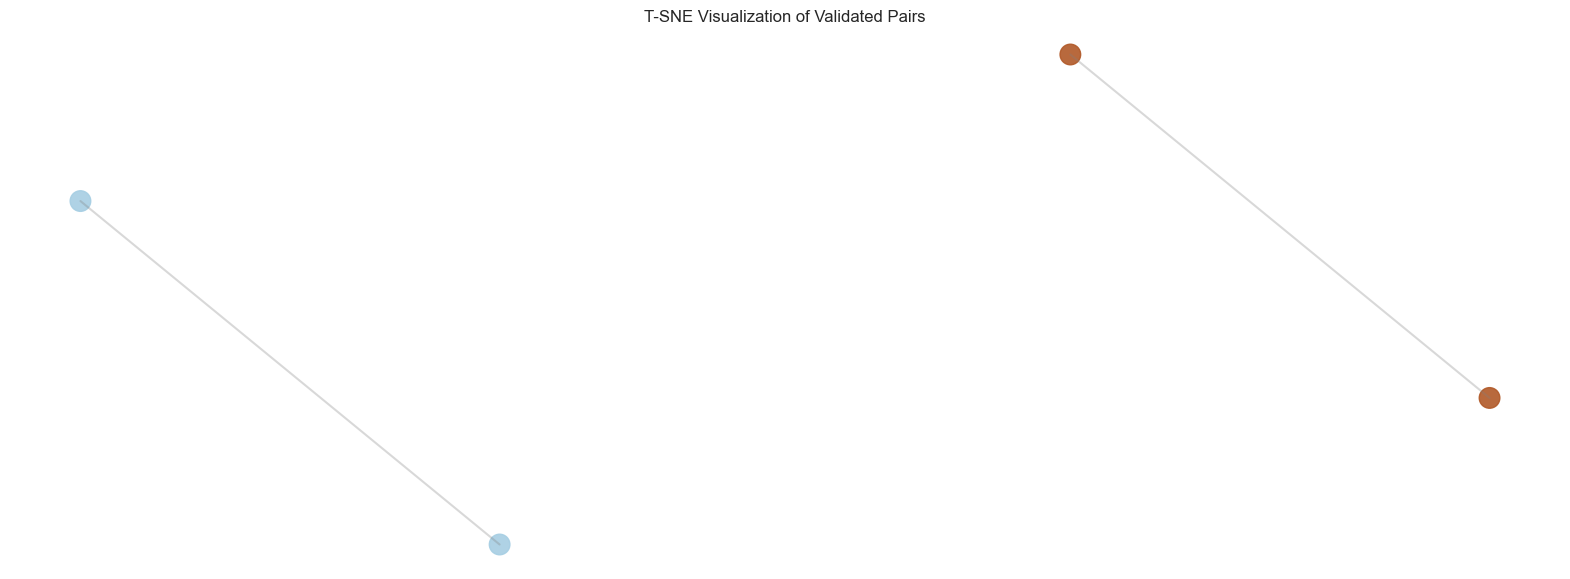

In [31]:
stocks = np.unique(pairs)
x_df = pd.DataFrame(index=returns.T.index,data=X)
pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs)) 
x_pairs = x_df.loc[stocks] 

x_tsne = TSNE(learning_rate=50,perplexity=3,random_state=42).fit_transform(x_pairs) 

plt.figure(figsize=(20,7)) 
plt.clf()
plt.axis('off') 

for pair in pairs:
    ticker1 = pair[0]
    loc1 = x_pairs.index.get_loc(pair[0]) 
    x1,y1 = x_tsne[loc1,:] 

    ticker2 = pair[0] 
    loc2 = x_pairs.index.get_loc(pair[1]) 
    x2,y2 = x_tsne[loc2,:] 

    plt.plot([x1,x2],[y1,y2],'k-',alpha=0.3,c='gray') 

plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s=220, alpha=0.9, c=pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');

### 6. Random pair behaviour visualization

In [32]:
import random 

ran_pair = random.choice(pairs)
ran_pair 

('THOMASCOOK.NS', '63MOONS.NS')

Pvalue for ('THOMASCOOK.NS', '63MOONS.NS') : 0.03535284670098314


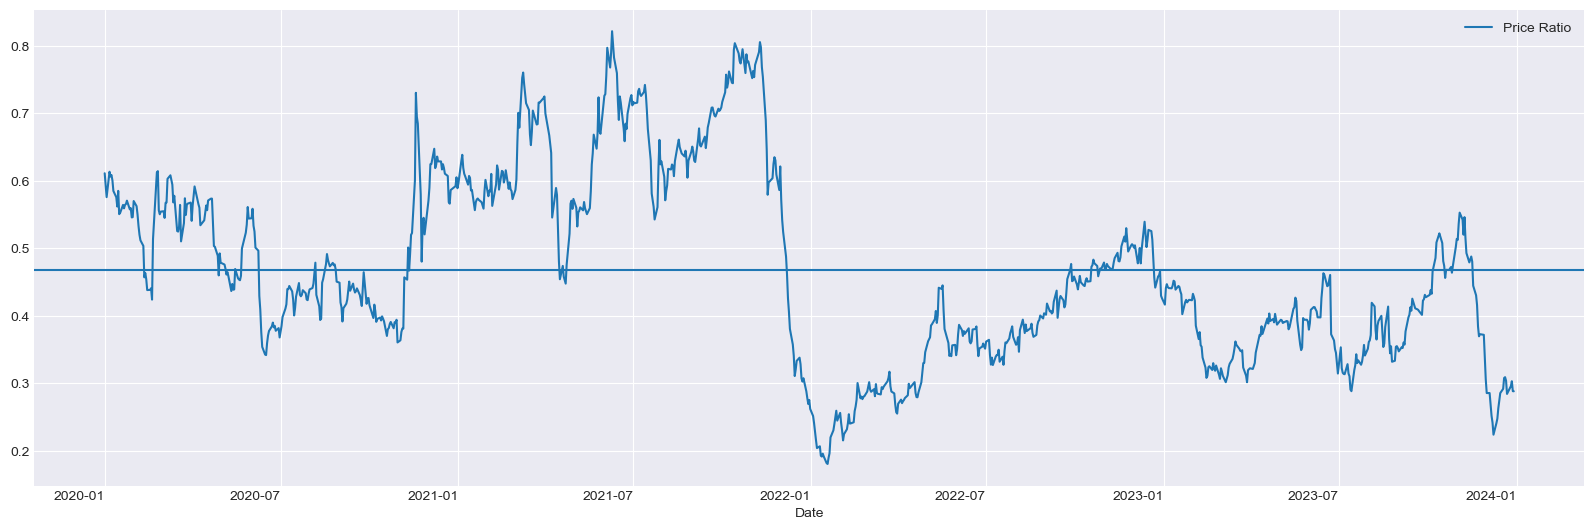

In [34]:
S1 = data[ran_pair[0]]
S2 = data[ran_pair[1]]
score,pvalue,_ = coint(S1,S2)
print(f'Pvalue for {ran_pair} : {pvalue}') 
ratio = S1/S2 
ratio.plot(figsize=(20,7)) 
plt.xticks(rotation=0)
plt.axhline(ratio.mean()) 
plt.legend(['Price Ratio']) 
plt.show() 

In [35]:
def zscore(series):
    return (series-series.mean())/np.std(series) 

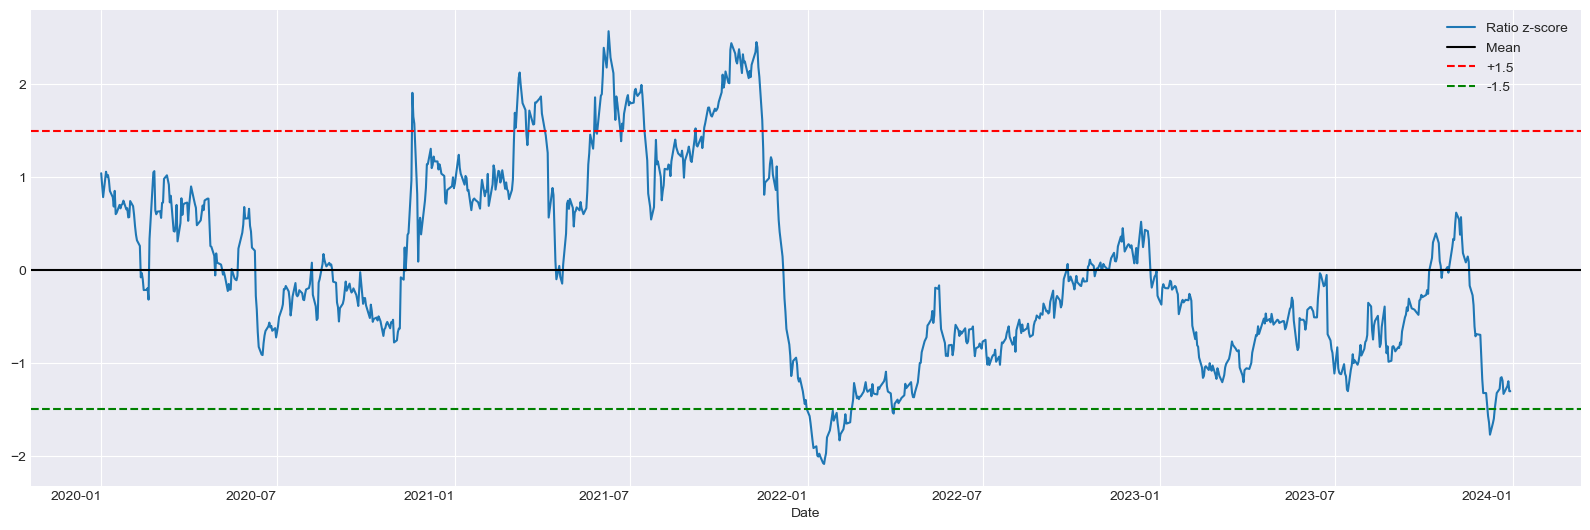

In [36]:
zscore(ratio).plot(figsize=(20,7))
plt.xticks(rotation=0)
plt.axhline(zscore(ratio).mean(),color='black') 
plt.axhline(1.5,color='red',linestyle='--')
plt.axhline(-1.5,color='green',linestyle='--') 
plt.legend(['Ratio z-score','Mean','+1.5','-1.5']) 
plt.show() 

### Strategy

* Go **Long** - whenever **ratio z-score** is below -1.5
* Go **Short** - whenever **ratio z-score** is above +1.5
* **Exit** - when z-score approaches zero 

Most often the historical prices maynot be the representative of today. For this reason, we often use rolling windows of the most recent data.

Instead of using ratio values, we use
* 1d Moving Average - to compute z-score
* 30d Moving Average - for mean
* 30d Standard Deviation - for std_dev 

In [37]:
ratios = S1/S2 
print(len(ratios)) 
train=ratios 

992


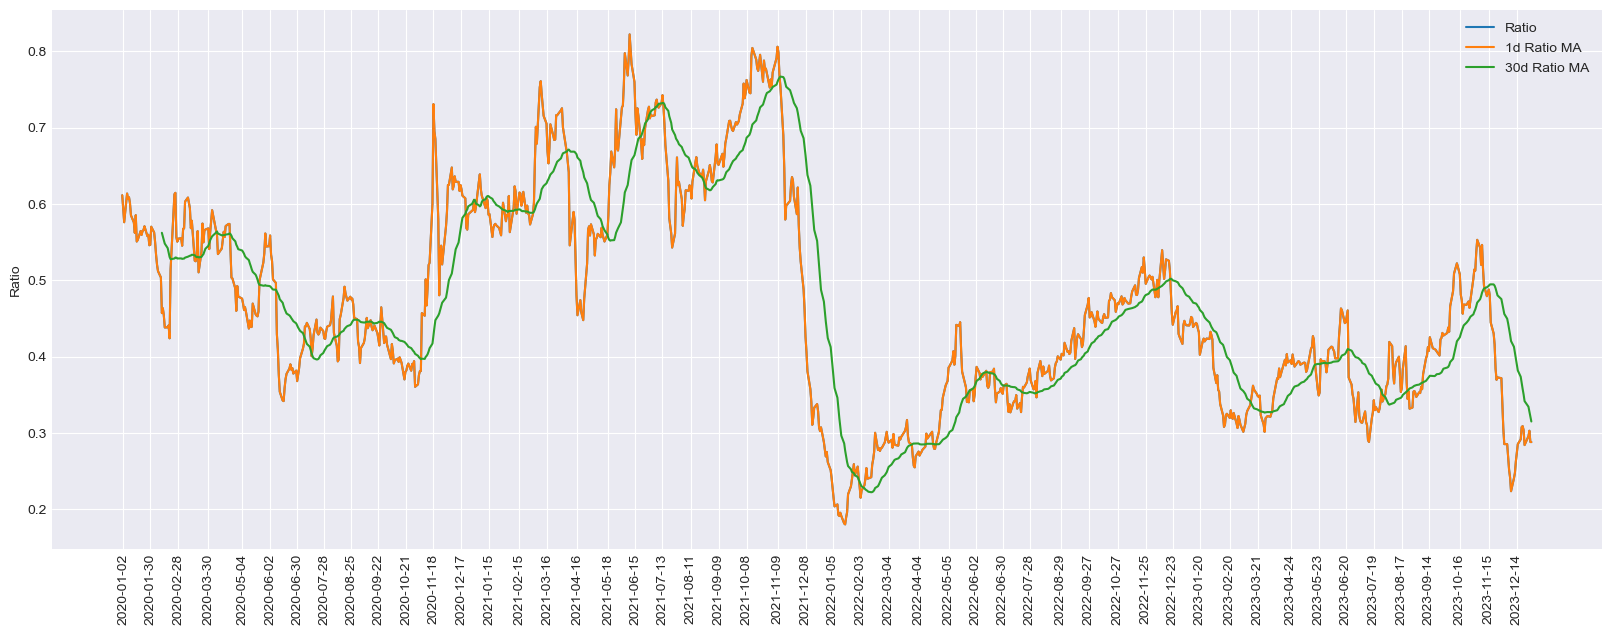

In [38]:
ratios_mavg1 = train.rolling(window=1,center=False).mean() 
ratios_mavg30 = train.rolling(window=30,center=False).mean() 
std_30 = train.rolling(window=30,center=False).std() 

zscore_30 = (ratios_mavg1-ratios_mavg30)/std_30 

plt.figure(figsize=(20,7))
plt.plot(train.index,train.values)
plt.plot(ratios_mavg1.index,ratios_mavg1.values) 
plt.plot(ratios_mavg30.index,ratios_mavg30.values) 

plt.legend(['Ratio','1d Ratio MA', '30d Ratio MA']) 
plt.xticks(returns.index[::20],rotation=90)
plt.ylabel('Ratio')
plt.show() 

Rolling 30 day standard deviation

In [39]:
std_30 = train.rolling(window=30,center=False).std() 
std_30.name = 'std 30d'

Compute z-score for each day

In [40]:
zscore_30_1 = (ratios_mavg1-ratios_mavg30)/std_30 
zscore_30_1.name = 'z-score'

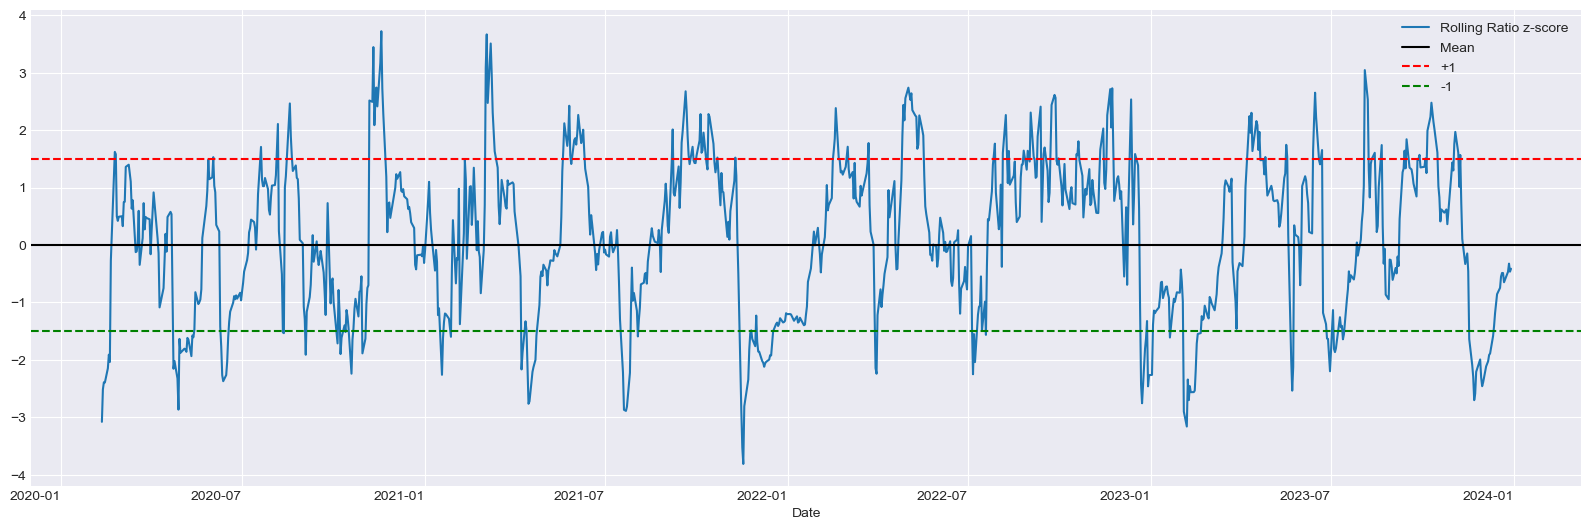

In [41]:
plt.figure(figsize=(20,7)) 
zscore_30_1.plot() 
plt.axhline(0,color='black') 
plt.xticks(rotation=0)
plt.axhline(1.5,color='red',linestyle='--') 
plt.axhline(-1.5,color='green',linestyle='--') 
plt.legend(['Rolling Ratio z-score','Mean','+1','-1']) 
plt.show() 

Plotting Buy ans Sell signal from z-score

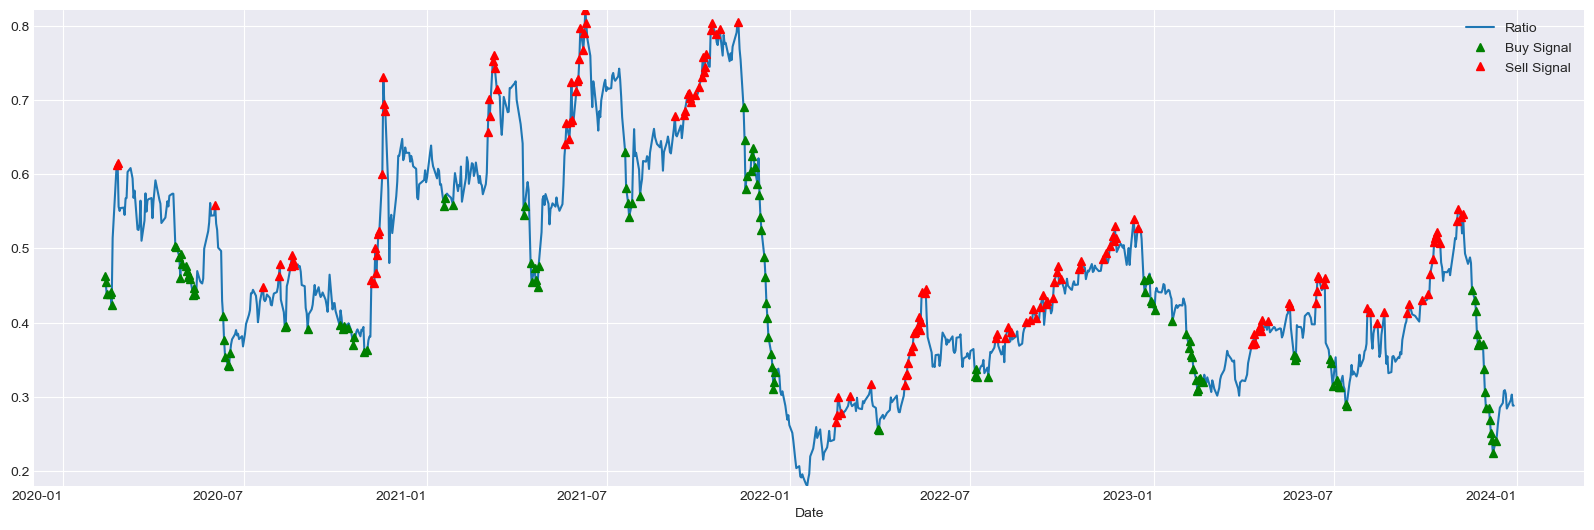

In [42]:
plt.figure(figsize=(20,7)) 
train[30:].plot() 
buy = train.copy()
sell = train.copy()

buy[zscore_30_1>-1.5] = 0
sell[zscore_30_1<1.5] = 0

buy[30:].plot(color='g',linestyle='None',marker='^') 
sell[30:].plot(color='r',linestyle='None',marker='^') 
x1,x2,y1,y2 = plt.axis() 
plt.xticks(rotation=0)
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio','Buy Signal','Sell Signal'])
plt.show() 

### Trading Algorithm

In [43]:
def trade(S1, S2, money, window1=1, window2=30):
    if window1==0 or window2==0: # If window length is 0, exit
        return 0
    
    ratios = S1/S2 
    ma1 = ratios.rolling(window=window1,center=False).mean() 
    ma2 = ratios.rolling(window=window2,center=False).mean() 
    std = ratios.rolling(window=window2,center=False).std() 

    zscore = (ma1-ma2)/std 

    # Simulate trading. Start with no money and no positions
    countS1, countS2, profit, c1, c2 = 0, 0, 0, 0, 0
    first_time = [0,0] 

    mon_list = pd.Series(index=returns.index) 
    mon_list[mon_list.index==returns.index[0]] = money 
    for i in range(len(ratios)):

        # Sell short if z-score>1.5
        if zscore[i]>1.5 and money>max(S1[i],S2[i]) and c1==0:
            countS1 -= int((money/2)/S1[i])
            countS2 += int((money/2)/S2[i])
            first_time = [S1[i],S2[i]]
            money -= -countS1*S1[i] + countS2*S2[i]
            c1 = 1 

        # Buy long if z-score<-1.5
        elif zscore[i]<-1.5 and money>max(S1[i],S2[i]) and c2==0:
            countS1 += int((money/2)/S1[i])
            countS2 -= int((money/2)/S2[i]) 
            first_time = [S1[i],S2[i]]     
            money -= countS1*S1[i]-countS2*S2[i]
            c2 = 1 

        # Clear positions if z-score between -0.1 and 0.1
        elif abs(zscore[i])<0.1:
            profit = countS1*(S1[i]-first_time[0])+countS2*(S2[i]-first_time[1]) 
            if(c1==1):
                money += -countS1*first_time[0] + countS2*first_time[1] + profit 
                c1 = 0
            if(c2==1):
                money += countS1*first_time[0] - countS2*first_time[1] + profit 
                c2 = 0 
            countS1 = 0
            countS2 = 0
            mon_list[mon_list.index==data.index[i]] = money      
    
    return mon_list           


In [44]:
cum_returns_nifty = (nifty_50-nifty_50[0])*100/nifty_50
cum_returns_nifty.name = 'NIFTY-50' 
cum_returns_nifty.tail() 

Date
2023-12-22    42.937507
2023-12-26    43.182215
2023-12-27    43.742135
2023-12-28    44.062316
2023-12-29    43.940566
Name: NIFTY-50, dtype: float64

In [45]:
benchmark = cum_returns_nifty[-1] 
print(f'benchmark is : {benchmark.round(0)}%') 

benchmark is : 44.0%


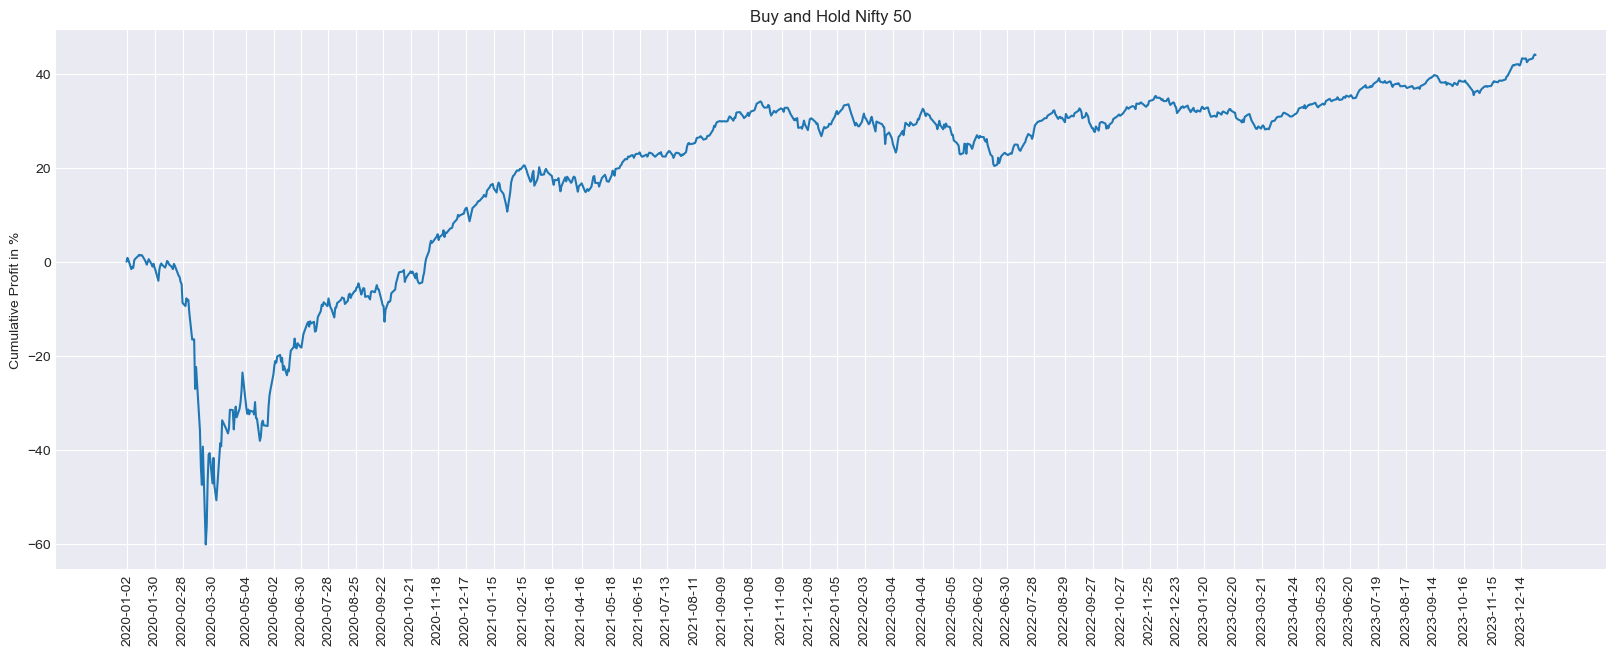

In [46]:
plt.figure(figsize=(20,7)) 
plt.plot(cum_returns_nifty) 
plt.xticks(returns.index[::20],rotation=90)
plt.ylabel('Cumulative Profit in %') 
plt.title('Buy and Hold Nifty 50') 
plt.show() 

### Trading all pairs listed by DBSCAN 

In [47]:
final_output = pd.DataFrame(index=returns.index) 
final_pairs = [] 

for pr in pairs:
    S1 = data[pr[0]]
    S2 = data[pr[1]] 
    initial_money = 100000
    amt_list = trade(S1,S2,initial_money)
    amt_list.fillna(method='ffill',inplace=True) 
    amt_list.name = pr[0]+'-'+pr[1]
    increment = (amt_list-initial_money)*100/initial_money
    if increment[-1]>benchmark:
        final_output = pd.concat([final_output,increment],axis=1)
        final_pairs.append(((increment[-1]),str(pr))) 

final_pairs.sort(reverse=True) 

In [48]:
new_columns = final_output.columns[final_output.loc[final_output.last_valid_index()].argsort()]
final_output=final_output[new_columns]
final_output = pd.concat([final_output,cum_returns_nifty],axis=1,join='inner')
final_output.tail() 

CYIENT.NS-SONATSOFTW.NS  THOMASCOOK.NS-63MOONS.NS   NIFTY-50
Date                                                                    
2023-12-22                52.945953                366.061862  42.937507
2023-12-26                52.945953                366.061862  43.182215
2023-12-27                52.945953                366.061862  43.742135
2023-12-28                52.945953                366.061862  44.062316
2023-12-29                52.945953                366.061862  43.940566

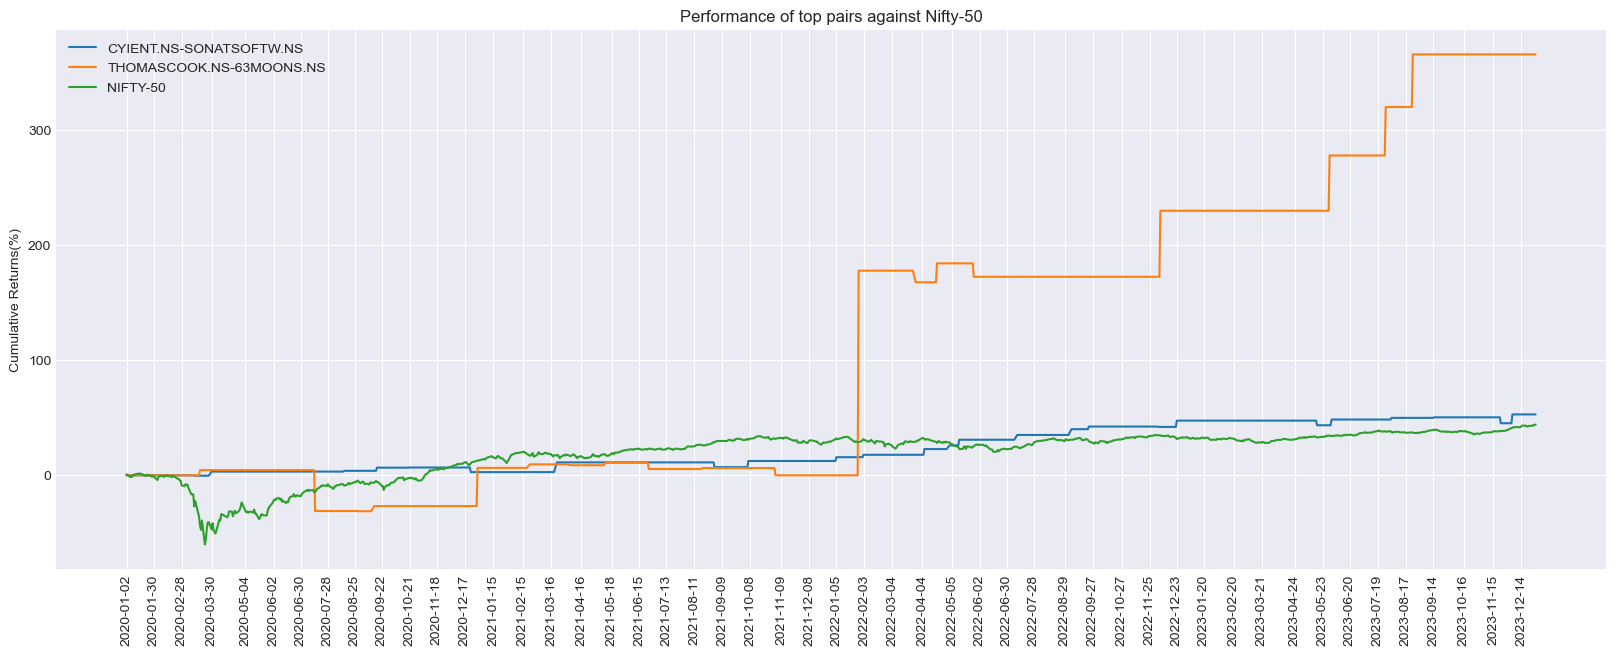

In [50]:
plt.figure(figsize=(20,7)) 
plt.plot(final_output.iloc[:,-6:],) 
plt.xticks(returns.index[::20],rotation=90) 
plt.ylabel('Cumulative Returns(%)') 
plt.title('Performance of top pairs against Nifty-50') 
plt.legend(final_output.columns[-6:]) 
plt.show() 

In [52]:
print(f'Total pairs outperforming benchmark = {len(final_pairs)}')
final_output.iloc[-1,:]

Total pairs outperforming benchmark = 2


CYIENT.NS-SONATSOFTW.NS      52.945953
THOMASCOOK.NS-63MOONS.NS    366.061862
NIFTY-50                     43.940566
Name: 2023-12-29 00:00:00, dtype: float64

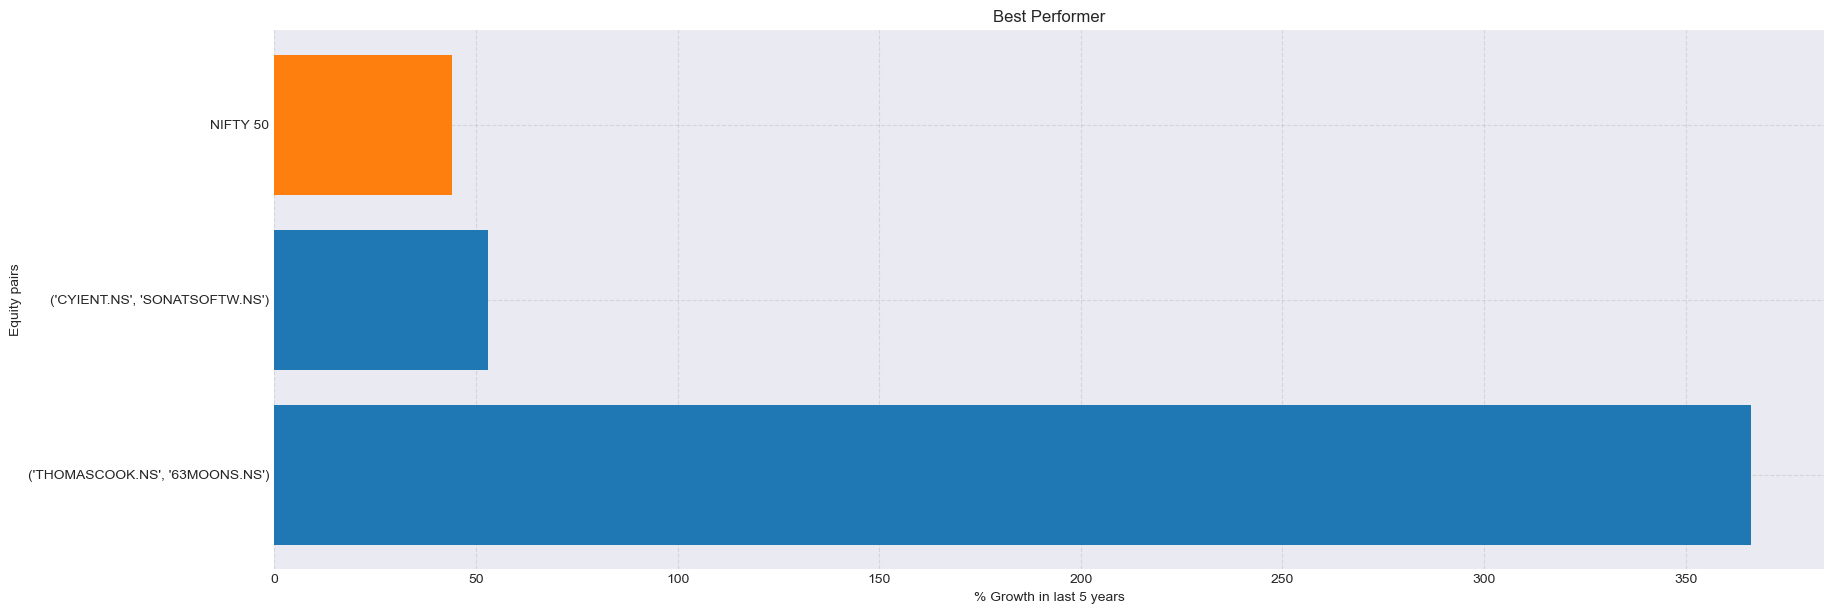

In [54]:
cum_profit = [] 
valuable_pairs = [] 
for l in final_pairs:
    cum_profit.append(l[0]) 
    valuable_pairs.append(l[1]) 
d_plot = pd.DataFrame(cum_profit,index=valuable_pairs)
fig,ax = plt.subplots(figsize=(20,7)) 
ax.grid(True,color='grey',linestyle='--',alpha=0.2)
ax.barh(d_plot.index,d_plot[0])    
ax.barh('NIFTY 50',benchmark)
ax.set_title('Best Performer')
plt.xlabel('% Growth in last 5 years') 
plt.ylabel('Equity pairs') 
plt.show()     